In [1]:
import datetime
import geopandas as gpd
import itertools
import numpy as np
import pandas as pd
import xarray as xr

import datacube

import sys

sys.path.insert(1, "../Tools/")
import dea_tools.bandindices
import dea_tools.datahandling
from dea_tools.spatial import xr_rasterize
from dea_tools.dask import create_local_dask_cluster
import dea_tools.wetlands

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

dc = datacube.Datacube(app="DEA_Wetlands_Insight_Tool")

<Client: 'tcp://127.0.0.1:45039' processes=1 threads=2, memory=12.21 GiB>

In [2]:
# some things I might change
time = ("2018-01-01", "2024-01-31")
# time = ('1985-01-01', '2024-01-01')

# Define which spectral bands are being used in the analysis
bands = [
    f"nbart_{band}" for band in ("blue", "green", "red", "nir", "swir_1", "swir_2")#, "panchromatic")
]

In [3]:
poly = gpd.read_file("site_metadata_sf/site_metadata_sf.shp")
poly.geometry[0] #
poly

Forest              Sitenam  AM_no AM_labl     Dt_dply Dt_rtrv  n_nghts  \
0    Barmah              Big Bog    1.0  ARI119  2022-10-11   44957    112.0   
1    Barmah              Big Bog    2.0  ARI255  2022-10-11   44957    112.0   
2   Millewa    Black Gate Lagoon    1.0   ARI86  2022-10-09   45015    172.0   
3   Millewa    Black Gate Lagoon    2.0    ARI1  2022-10-09   45015    172.0   
4    Barmah      Boals Deadwoods    1.0  ARI244  2022-10-04   44959    121.0   
5    Barmah      Boals Deadwoods    2.0  ARI226  2022-10-04   44959    121.0   
6    Barmah       Bucks Crossing    1.0  ARI280  2022-10-11   44956    111.0   
7    Barmah       Bucks Crossing    2.0  ARI133  2022-10-11   44956    111.0   
8    Barmah  Bunyip Gully Gowers    1.0  ARI242  2022-10-08   44957    115.0   
9    Barmah  Bunyip Gully Gowers    2.0   ARI32  2022-10-08   44957    115.0   
10   Barmah     Bunyip Waterhole    2.0  ARI272  2022-10-08   44957    115.0   
11  Millewa        Burial Lagoon    1.0   ARI12  2022-10-09   45015    172.0   
12  Millewa        Burial Lagoon    2.0   ARI99  2022-10-09   45015    172.0   
13  Millewa          Duck Lagoon    1.0  ARI137  2022-10-09   45019    176.0   
14  Millewa          Duck Lagoon    2.0   ARI31  2022-10-09   45019    176.0   
15   Barmah            Gooseneck    1.0  ARI228  2022-10-08   44958    116.0   
16  Millewa     Horseshoe Lagoon    1.0  ARI234  2022-10-09   45015    172.0   
17  Millewa     Horseshoe Lagoon    2.0  ARI248  2022-10-09   45015    172.0   
18  Millewa         Lowries Pump    1.0  ARI231  2022-10-04   45017    179.0   
19  Millewa         Lowries Pump    2.0  ARI261  2022-10-04   45017    179.0   
20   Barmah             Mannions    1.0  ARI251  2022-10-11   44956    111.0   
21   Barmah             Mannions    2.0  ARI112  2022-10-11   44956    111.0   
22  Millewa      Pinchgut Lagoon    1.0  ARI147  2022-10-04   45017    179.0   
23  Millewa      Pinchgut Lagoon    2.0  ARI249  2022-10-04   45017    179.0   
24  Millewa             Quambies    1.0    ARI5  2022-10-09   45018    175.0   
25  Millewa       Reed Bed Swamp    1.0  ARI126  2022-10-09   45019    176.0   
26  Millewa       Reed Bed Swamp    2.0   ARI90  2022-10-09   45019    176.0   
27   Barmah              Rookery    2.0  ARI227  2022-10-11   44956    111.0   
28   Barmah   Two Mile Sandridge    1.0  ARI230  2022-10-08   44958    116.0   
29   Barmah   Two Mile Sandridge    2.0  ARI110  2022-10-08   44958    116.0   
30  Millewa          Warri Yards    1.0  ARI243  2022-10-09   45018    175.0   
31  Millewa          Warri Yards    2.0  ARI193  2022-10-09   45018    175.0   
32   Barmah         Whores Creek    1.0  ARI247  2022-10-04   44959    121.0   
33   Barmah         Whores Creek    2.0  ARI266  2022-10-04   44956    118.0   

    n_mnths D___(o)  N_srvy_  \
0       4.0   44956    111.0   
1       4.0   44956    111.0   
2       6.0   45014    171.0   
3       6.0   44848      5.0   
4       4.0   44958    120.0   
5       4.0   44958    120.0   
6       4.0   44957    112.0   
7       4.0   44957    112.0   
8       4.0   44958    116.0   
9       4.0   44958    116.0   
10      4.0   44958    116.0   
11      6.0   45014    171.0   
12      6.0   45014    171.0   
13      6.0   45018    175.0   
14      6.0   44915     72.0   
15      4.0   44857     15.0   
16      6.0   45014    171.0   
17      6.0   45014    171.0   
18      6.0   45016    178.0   
19      6.0   45016    178.0   
20      4.0   44957    112.0   
21      4.0   44957    112.0   
22      6.0   45016    178.0   
23      6.0   45016    178.0   
24      6.0   45017    174.0   
25      6.0   45018    175.0   
26      6.0   45018    175.0   
27      4.0   44957    112.0   
28      4.0   44959    117.0   
29      4.0   44959    117.0   
30      6.0   45017    174.0   
31      6.0   45017    174.0   
32      4.0   44929     91.0   
33      4.0   44957    119.0   

                                              Comment  \
0                         

In [5]:
for index, wetland in poly.iterrows():
    index

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 224 time steps as a dask array


/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


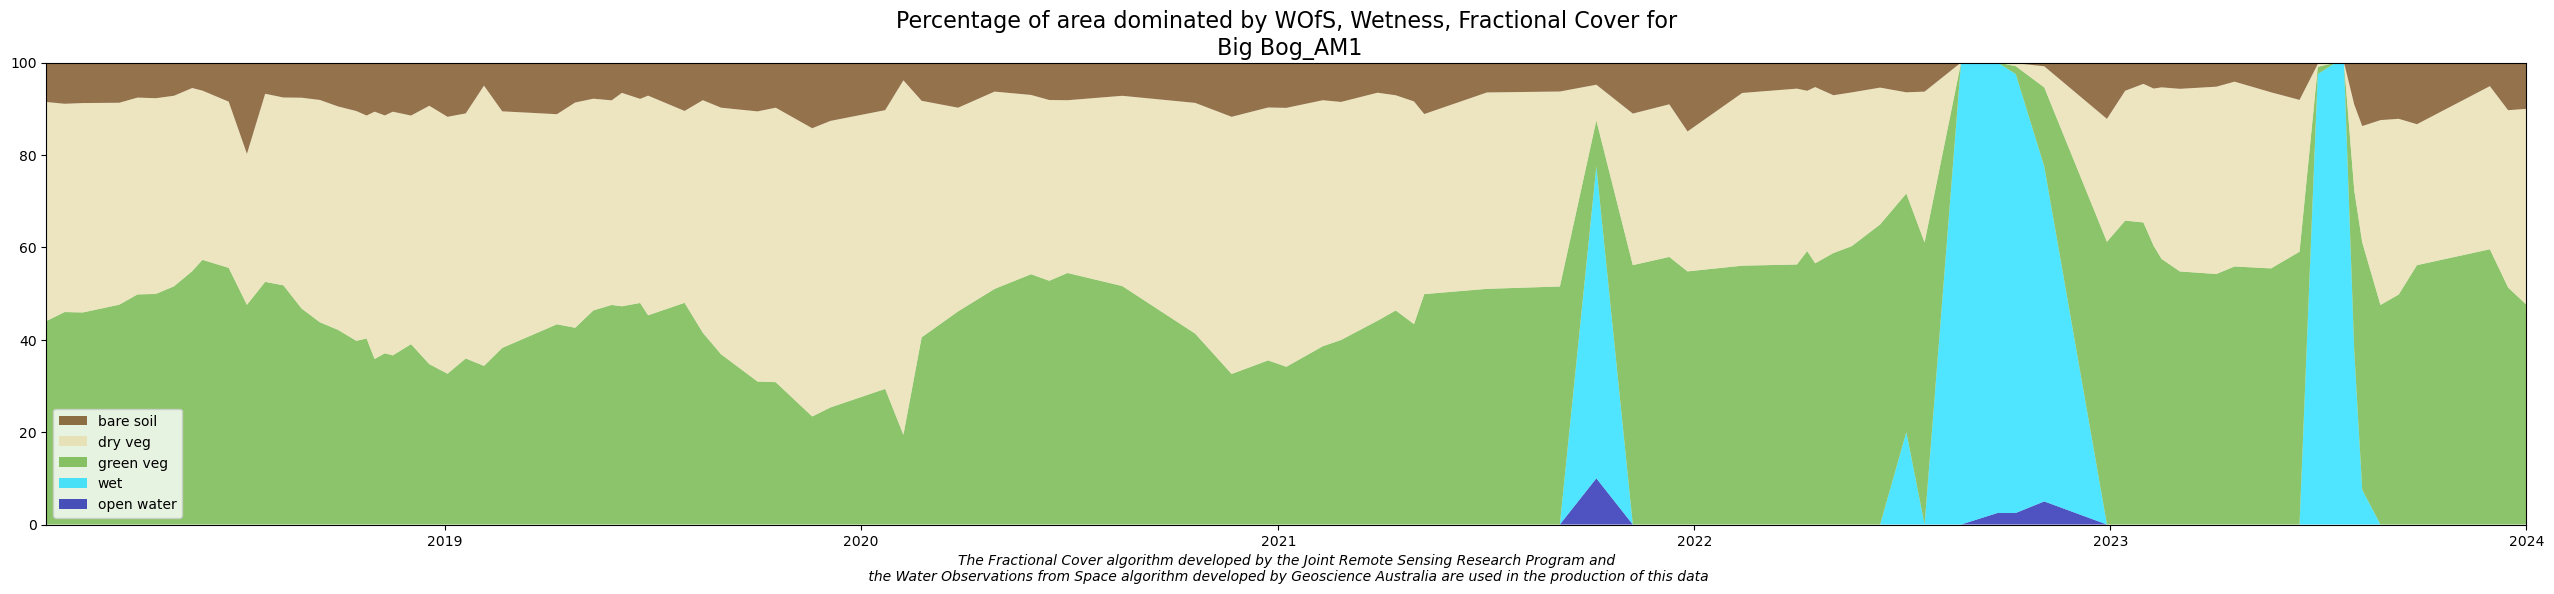

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 222 time steps as a dask array
Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


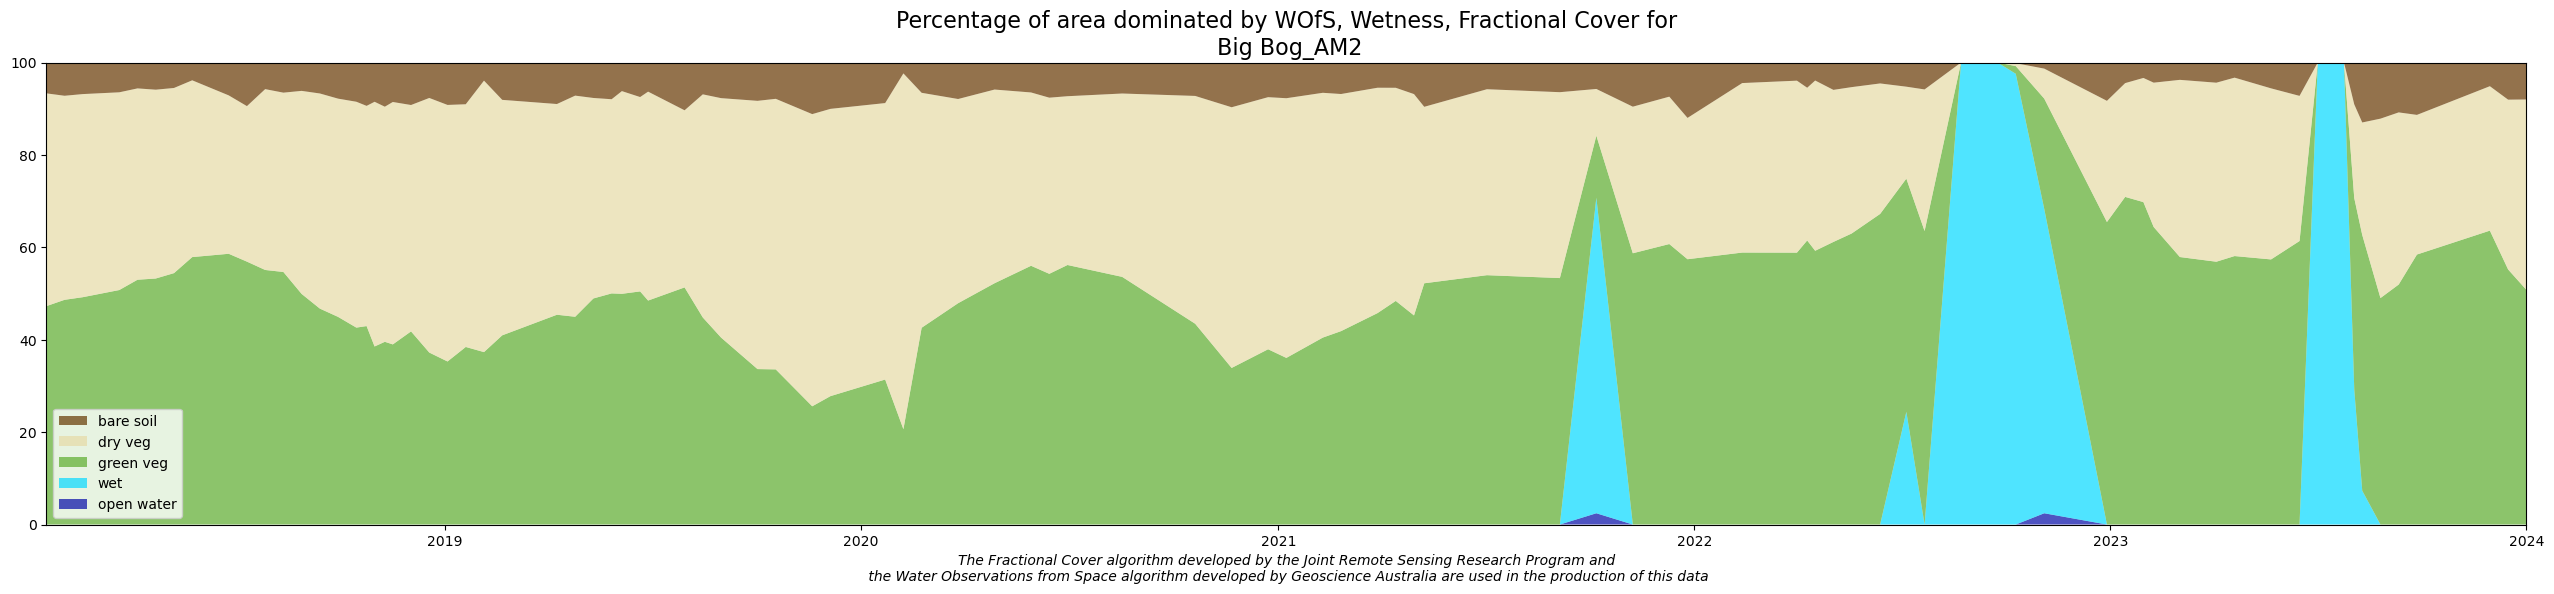

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 03:48:52,910 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


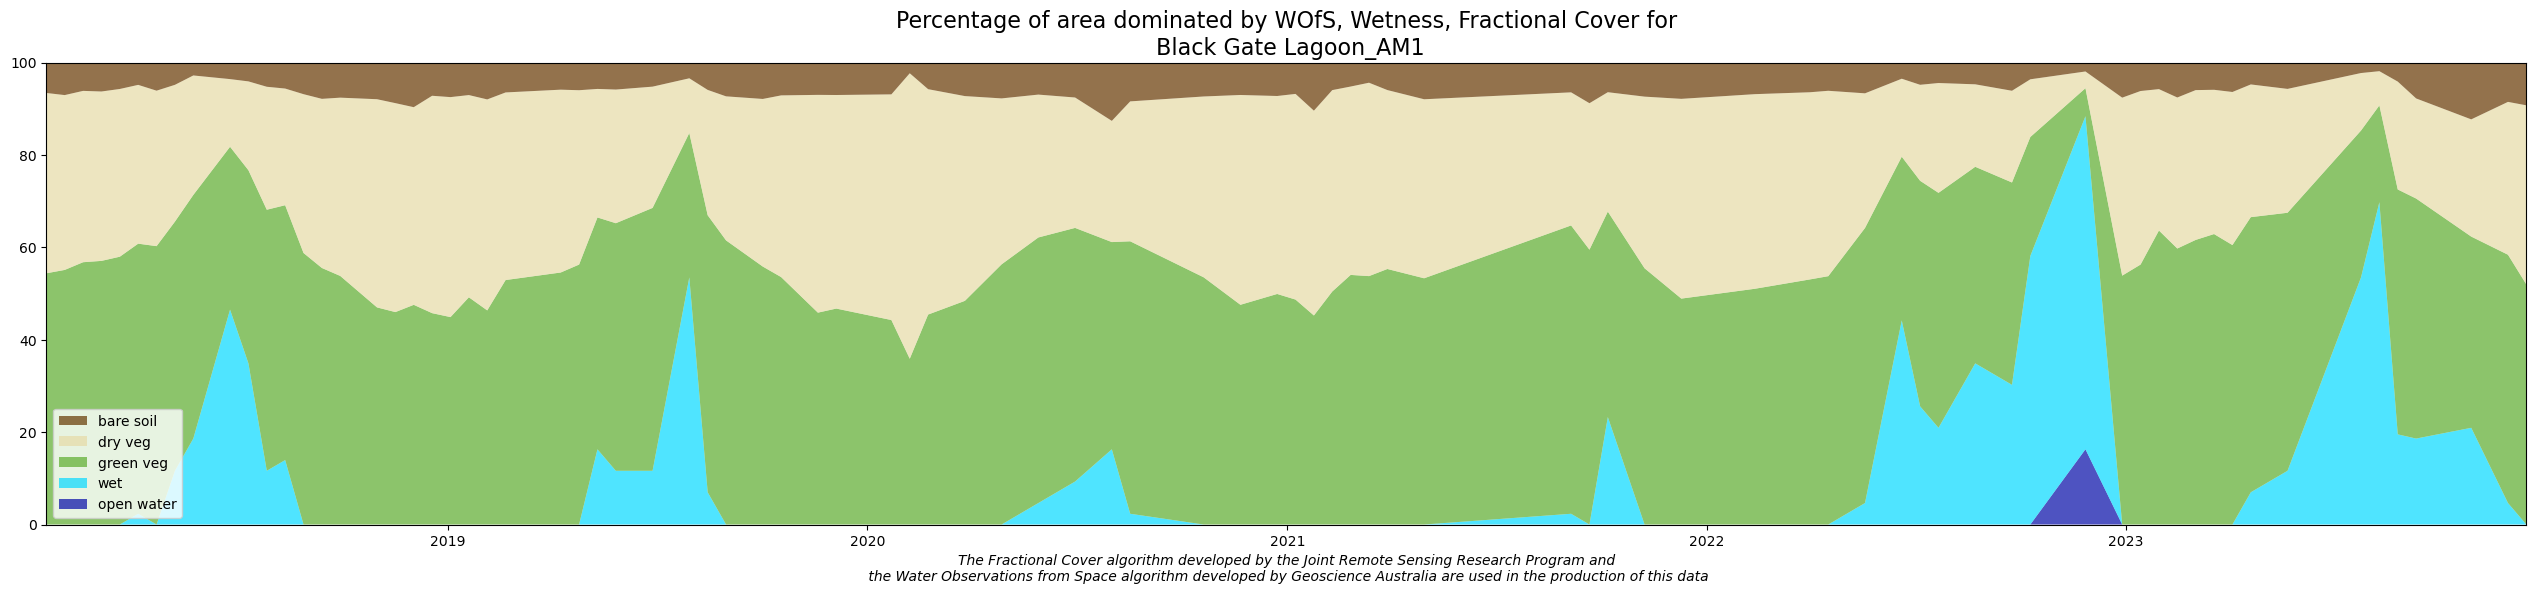

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 03:49:42,877 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2024-04-05 03:50:19,430 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2024-04-05 03:50:22,822 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2024-04-05 03:50:32,341 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2024-04-05 03:50:54,103 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


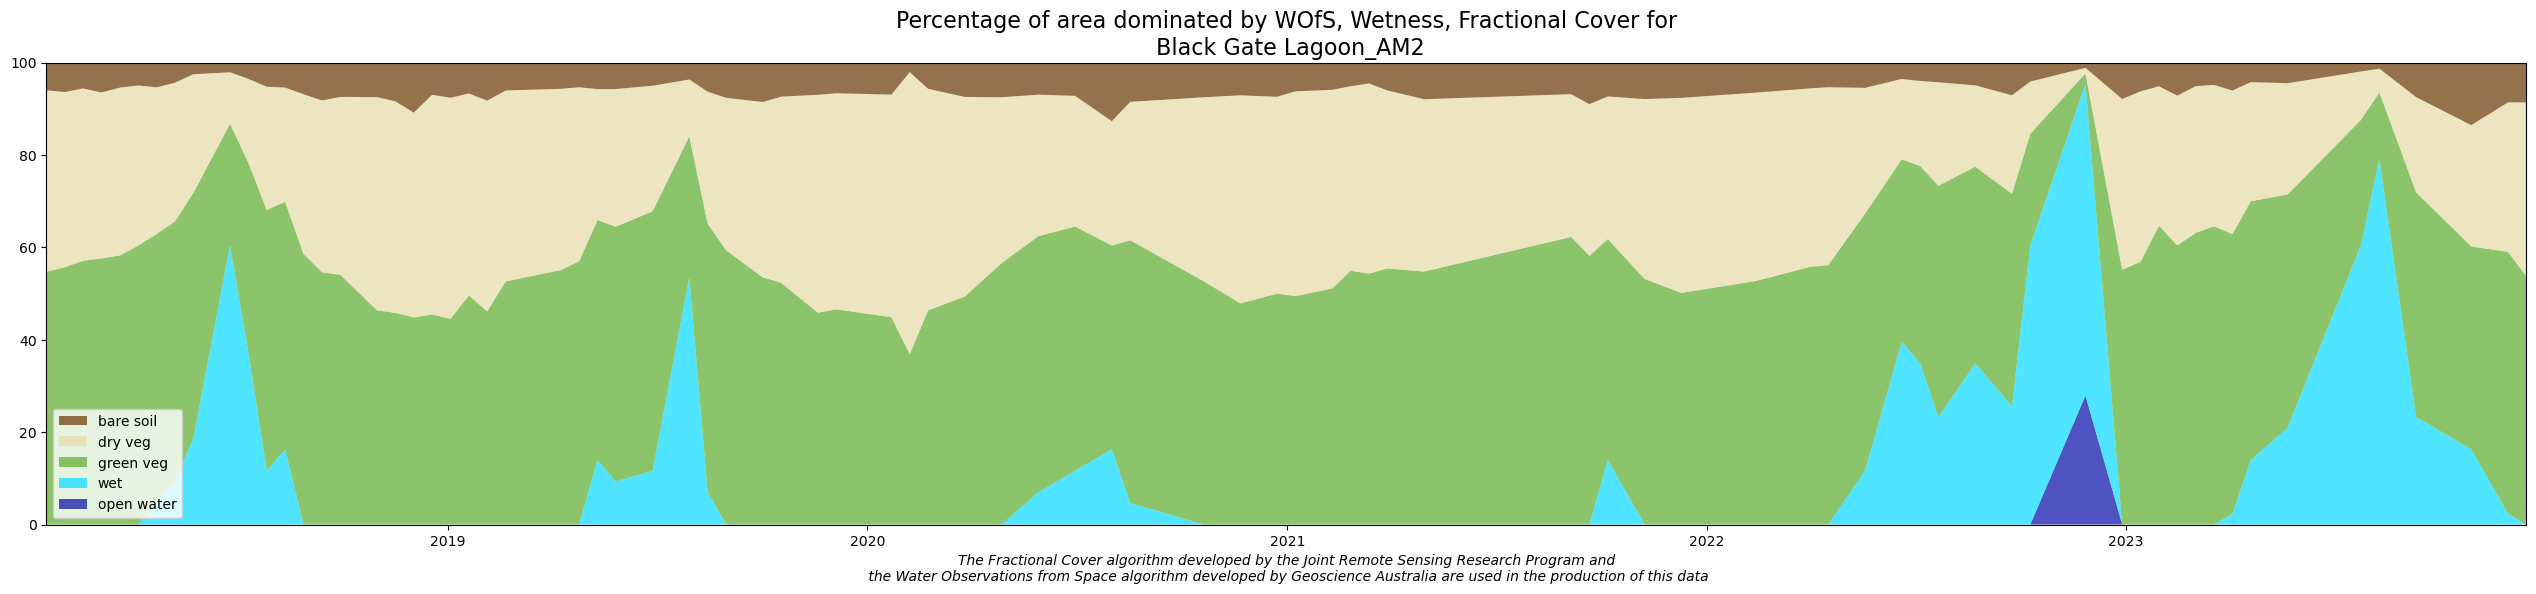

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 03:51:26,748 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2024-04-05 03:52:00,514 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2024-04-05 03:52:33,026 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2024-04-05 03:52:36,374 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2024-04-05 03:52:50,351 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2024-04-05 03:53:13,530 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


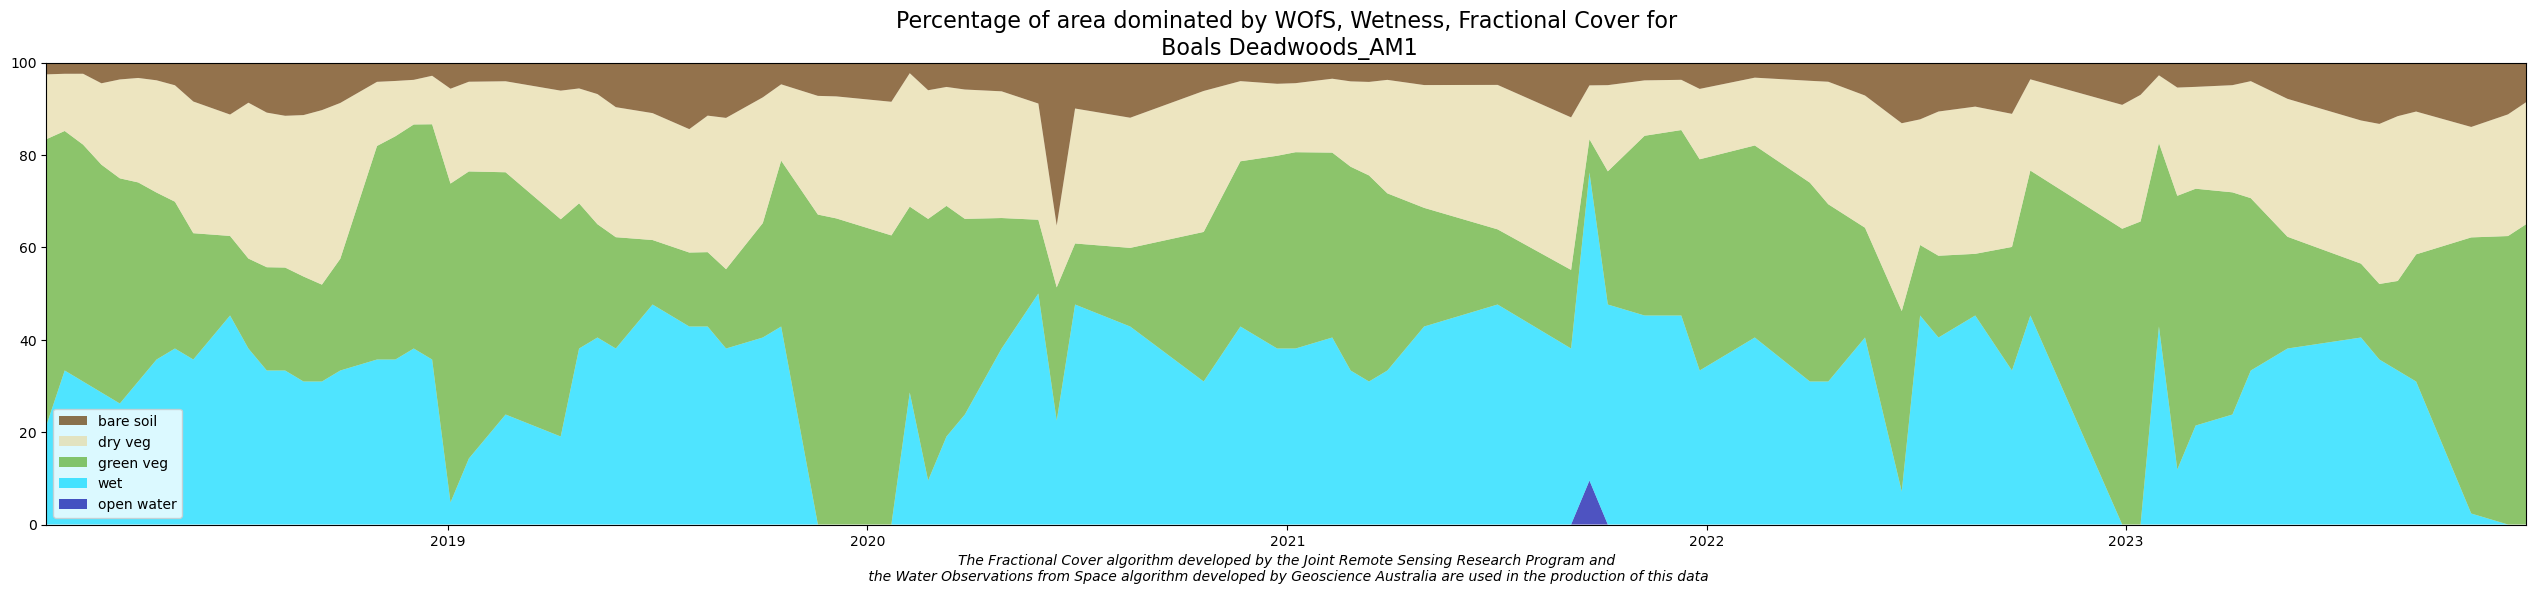

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 03:53:48,403 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2024-04-05 03:54:20,642 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2024-04-05 03:54:28,391 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2024-04-05 03:54:40,832 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2024-04-05 03:55:00,241 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


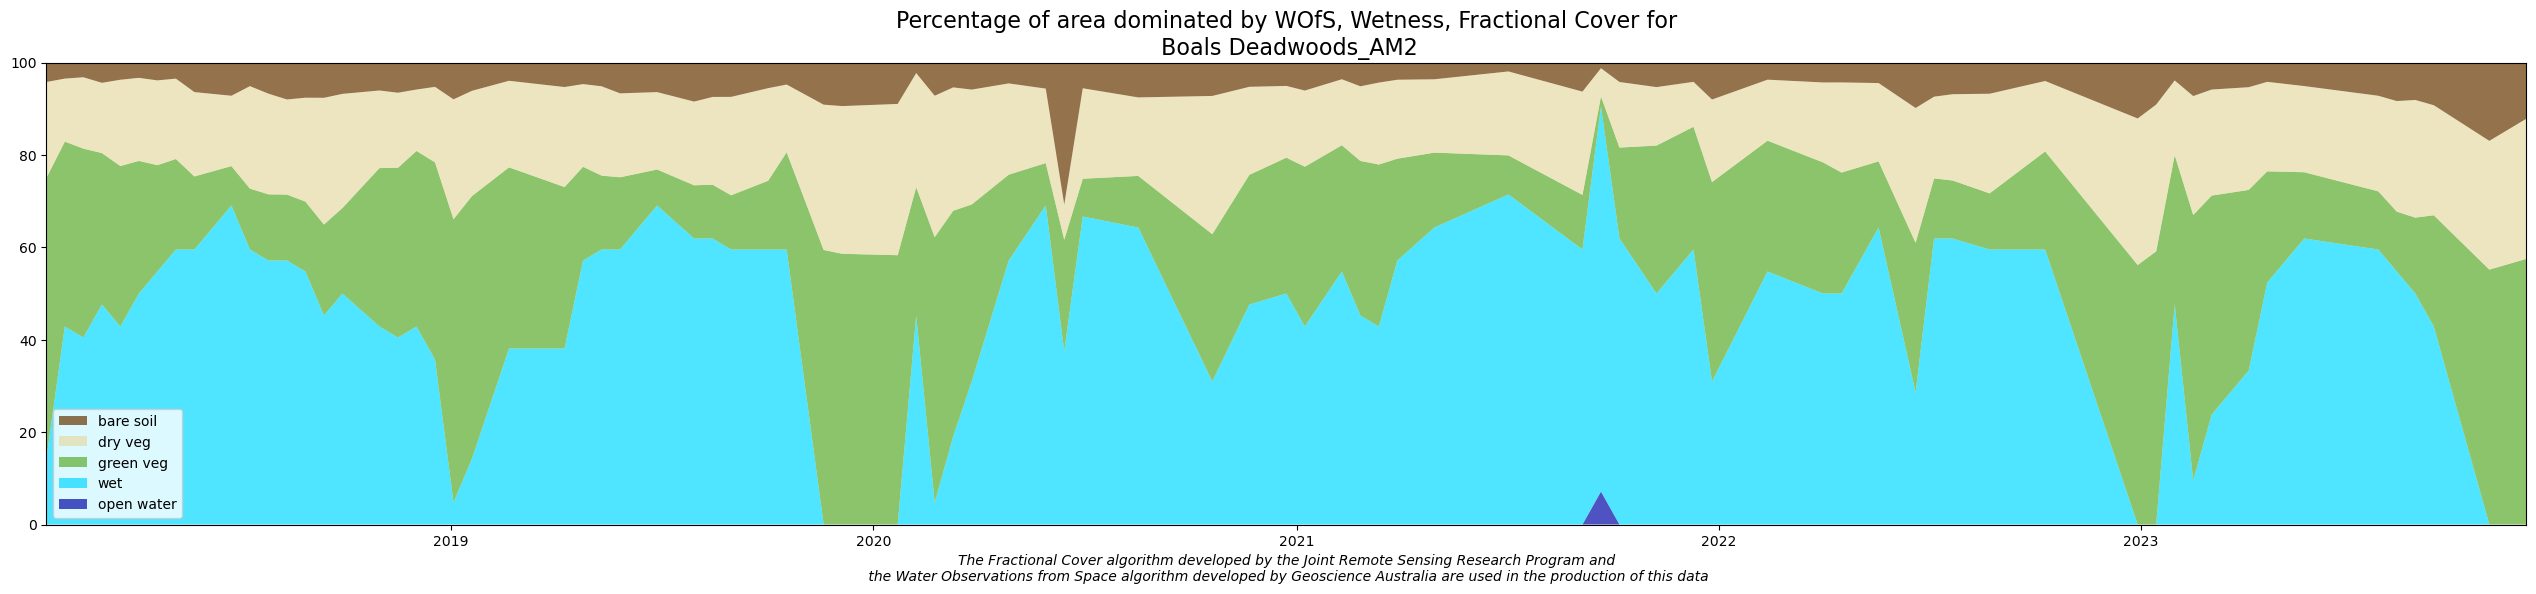

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 03:55:33,816 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2024-04-05 03:56:02,154 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2024-04-05 03:56:06,073 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2024-04-05 03:56:20,725 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2024-04-05 03:56:40,410 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


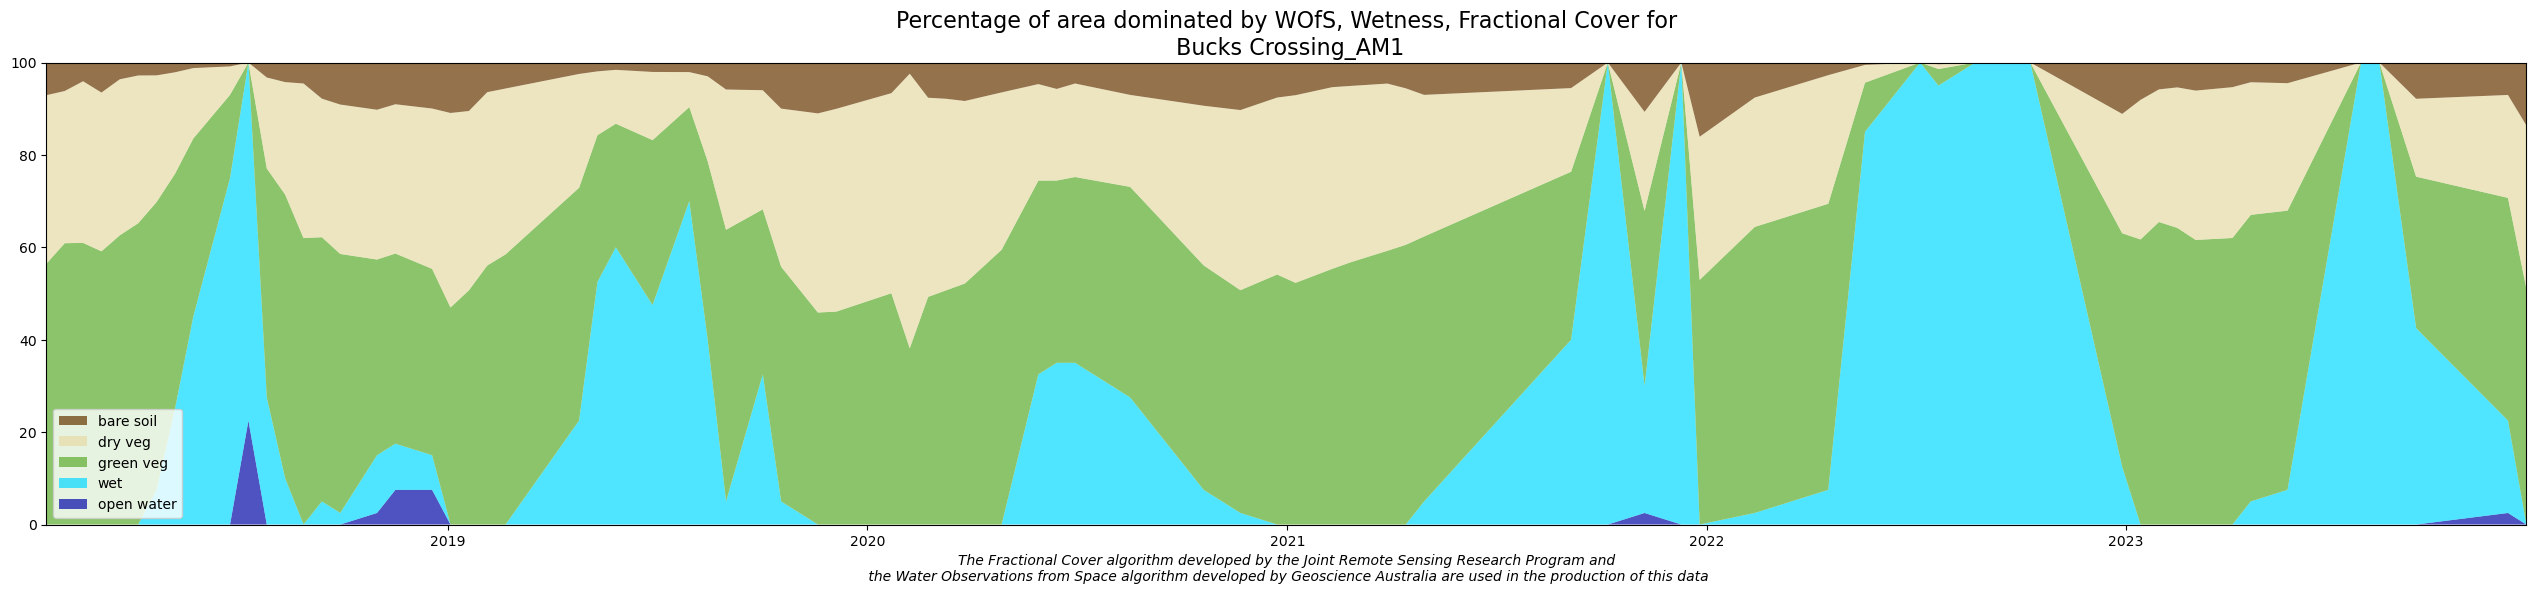

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 03:57:15,251 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2024-04-05 03:57:33,021 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2024-04-05 03:57:38,547 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2024-04-05 03:57:52,875 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


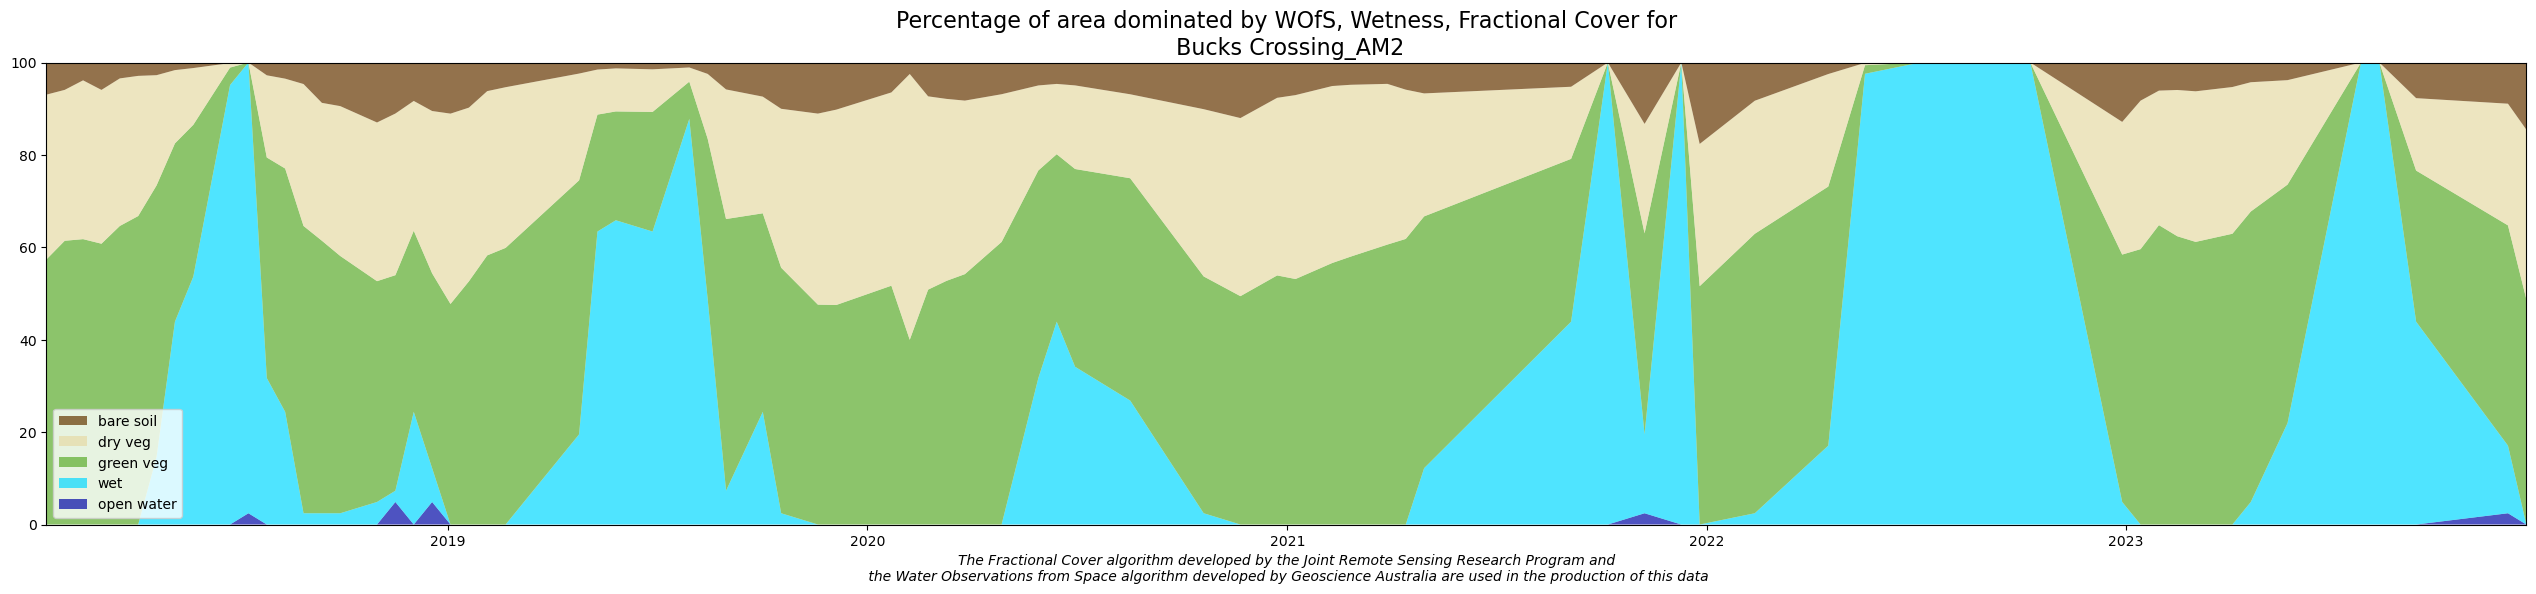

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 03:58:15,473 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2024-04-05 03:58:38,151 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2024-04-05 03:58:50,216 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2024-04-05 03:59:00,730 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2024-04-05 03:59:17,197 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


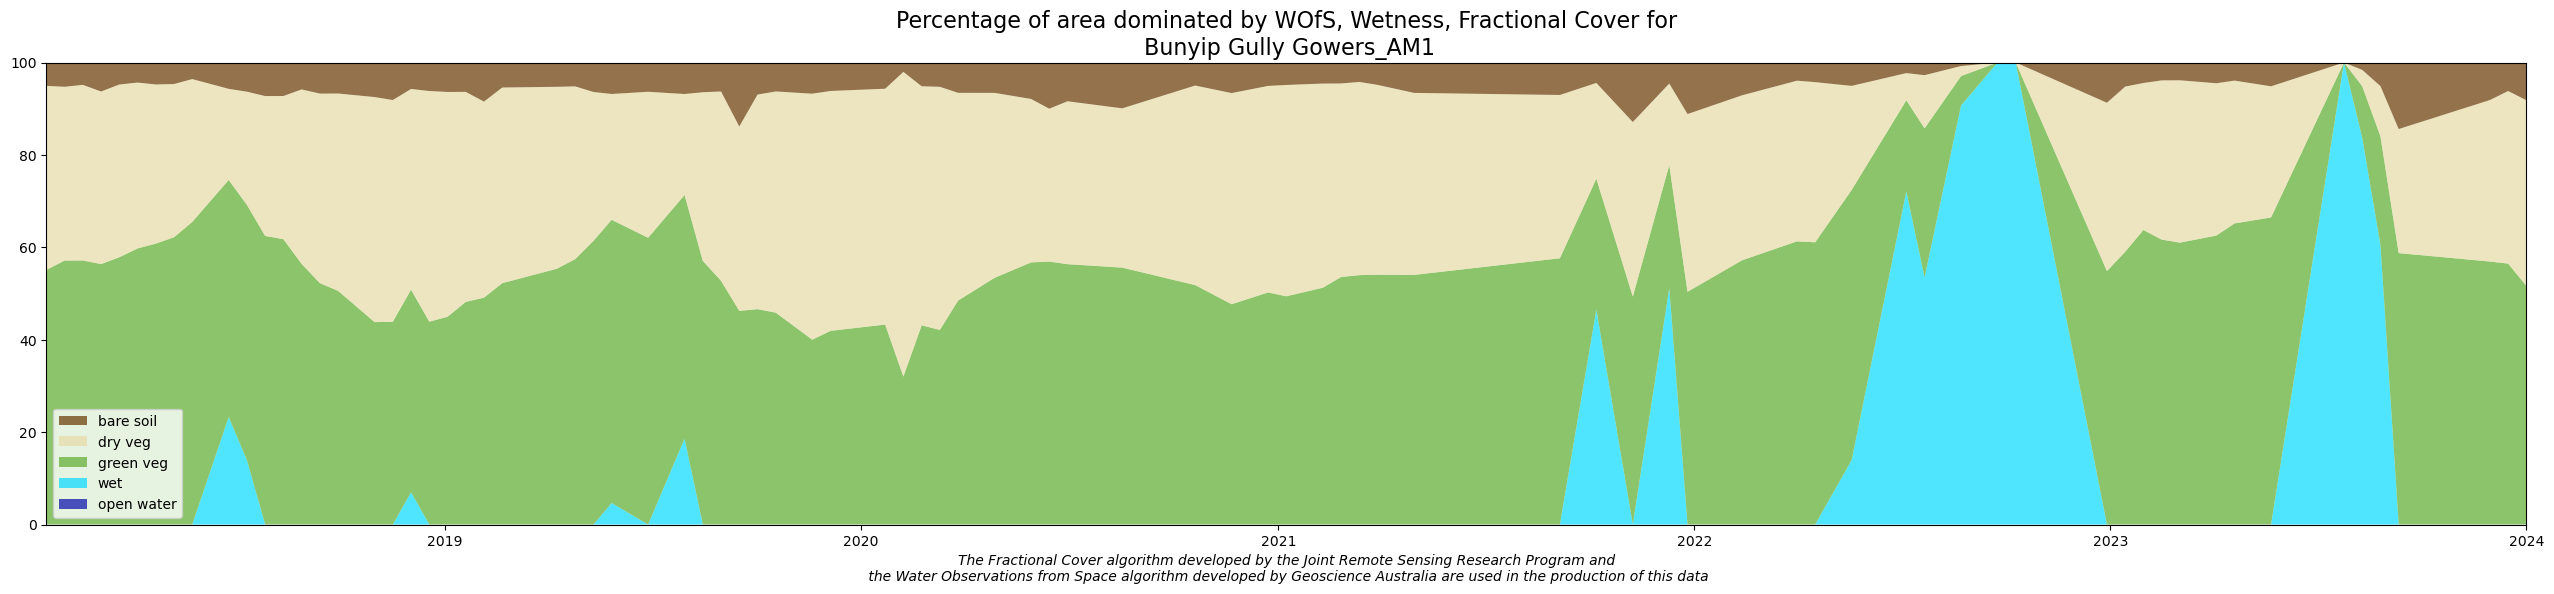

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 03:59:45,276 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2024-04-05 04:00:01,144 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2024-04-05 04:00:07,088 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2024-04-05 04:00:21,094 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


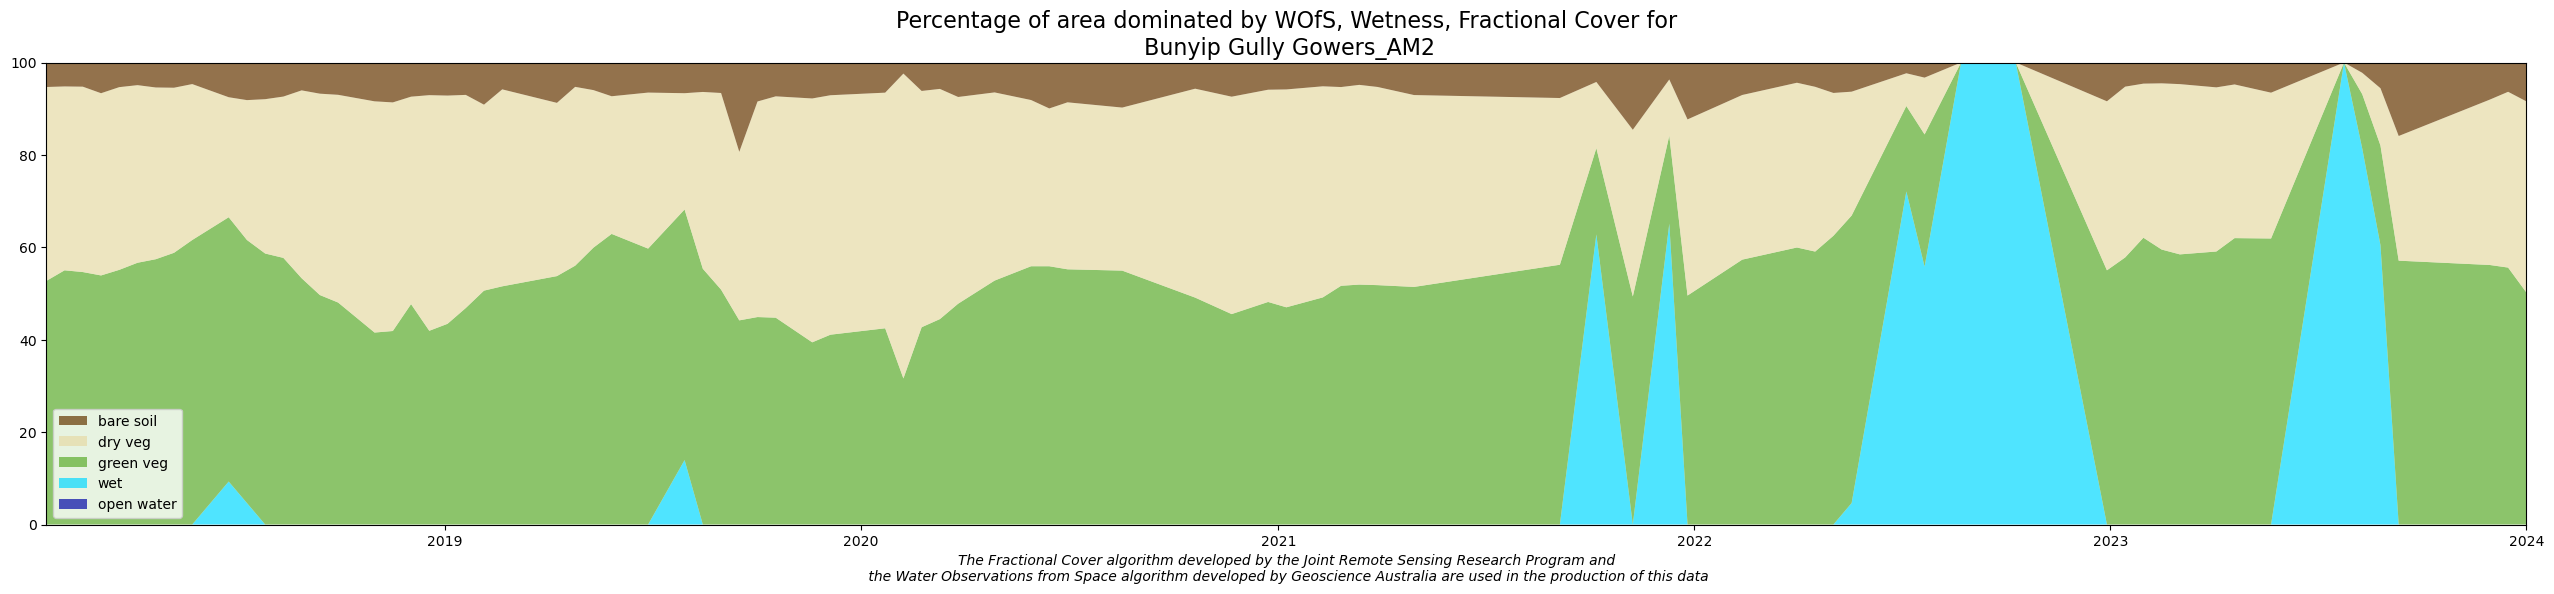

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 04:00:44,293 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2024-04-05 04:01:07,747 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2024-04-05 04:01:12,064 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2024-04-05 04:01:24,331 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


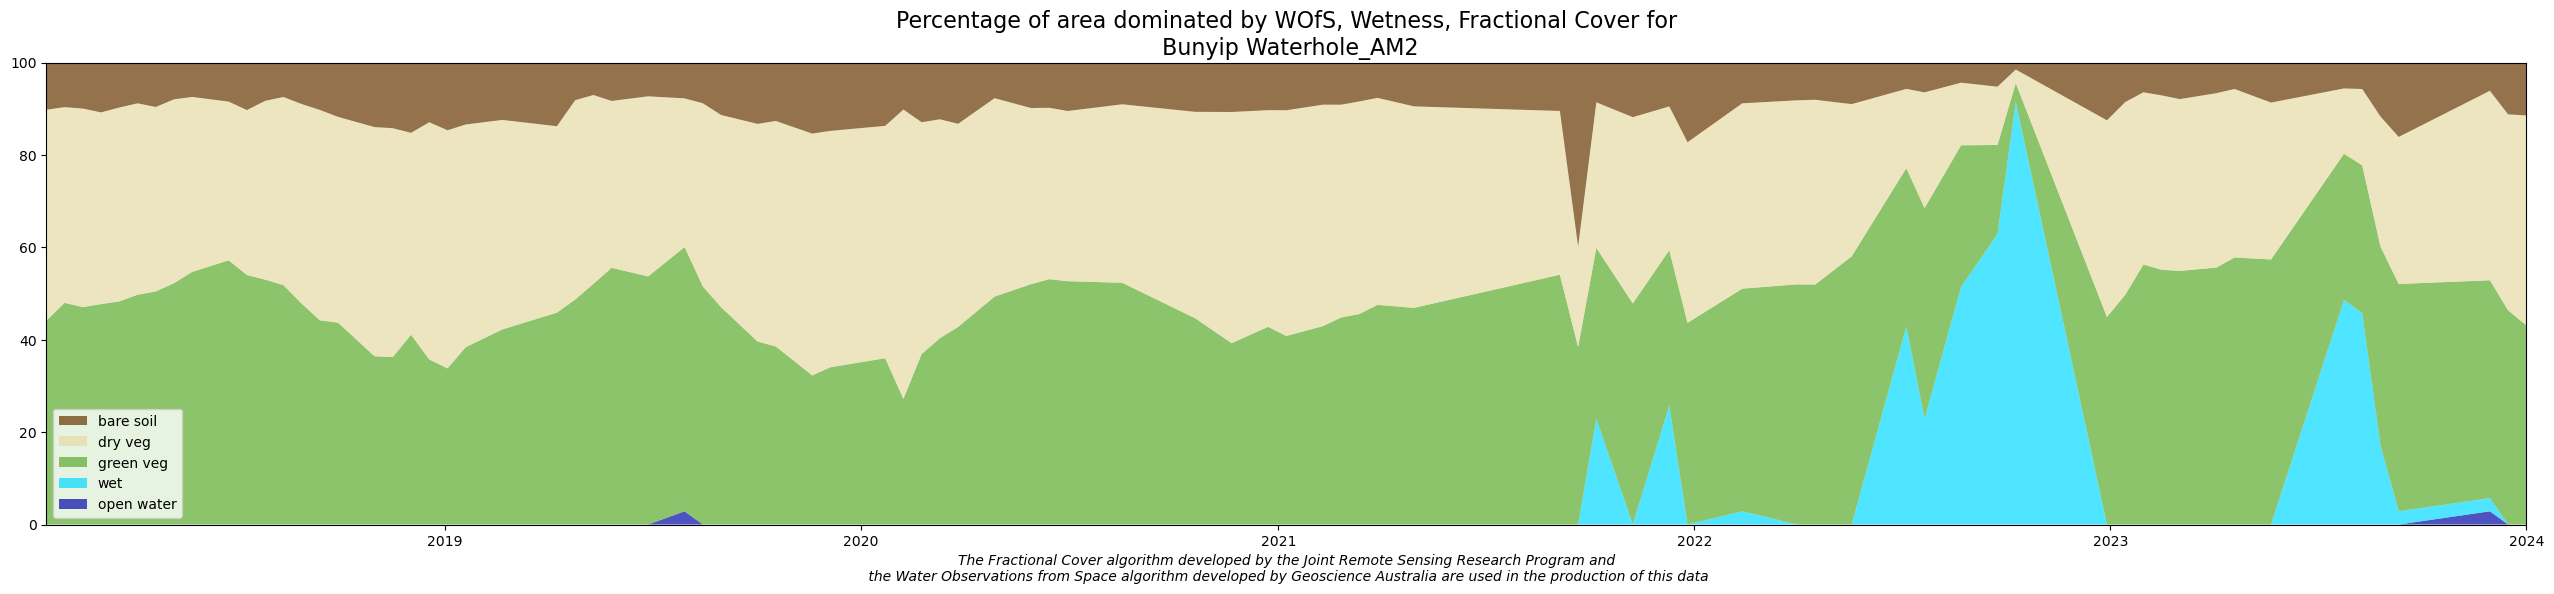

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 04:01:43,212 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2024-04-05 04:02:20,264 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2024-04-05 04:02:41,320 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2024-04-05 04:02:50,933 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2024-04-05 04:03:10,391 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


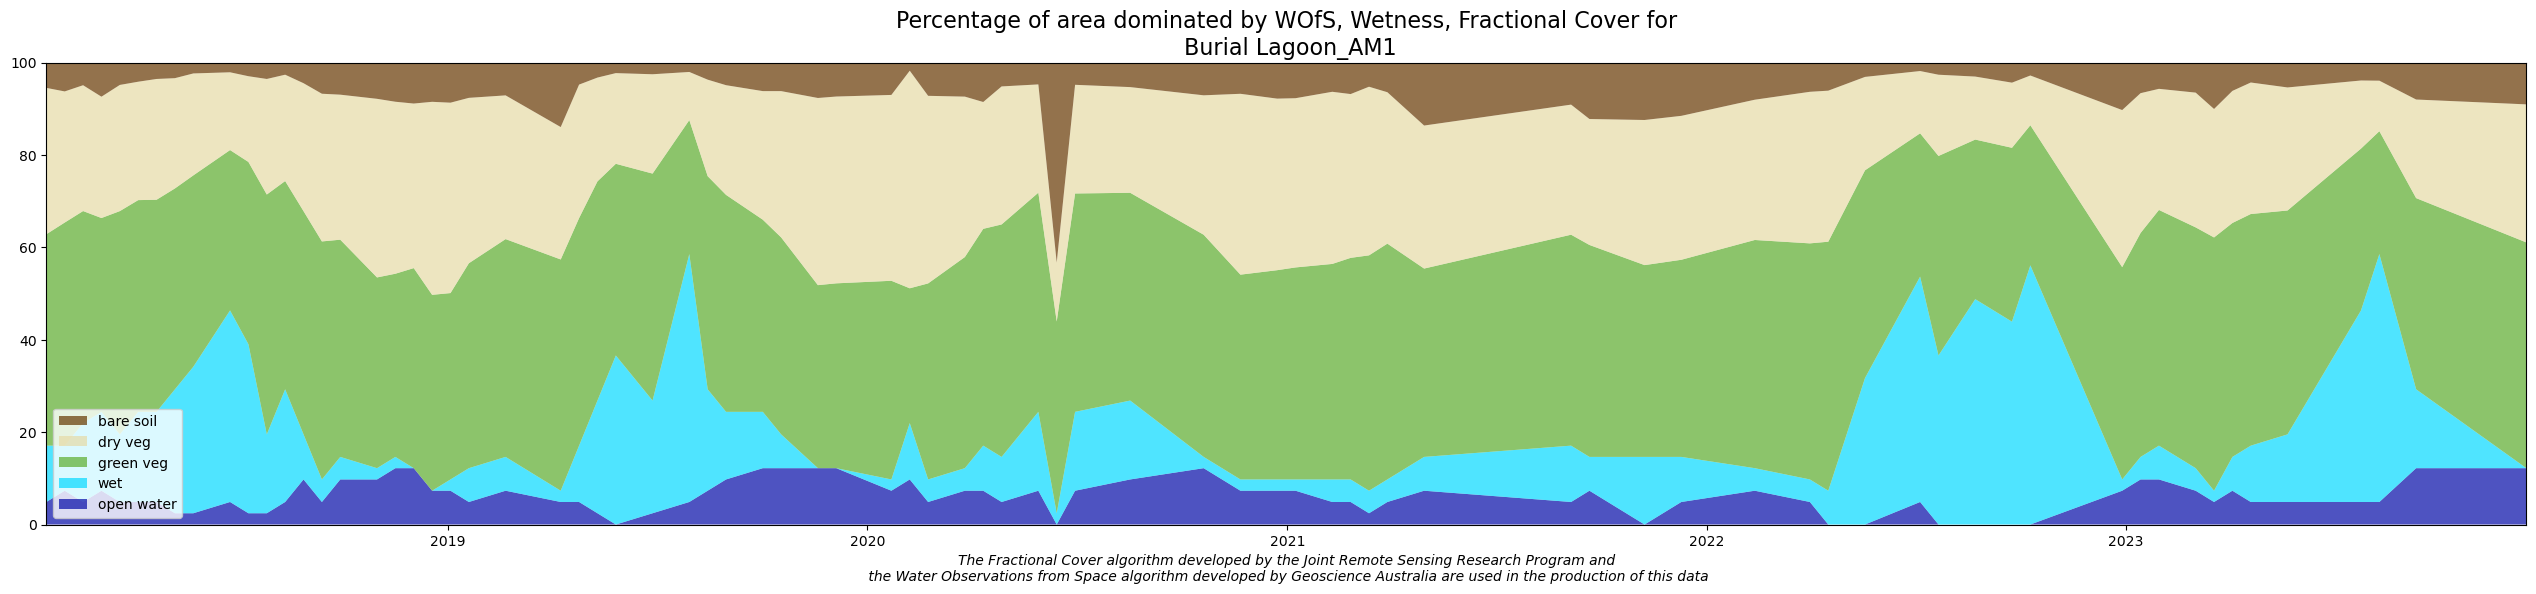

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 04:03:49,491 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2024-04-05 04:04:07,499 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2024-04-05 04:04:18,502 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2024-04-05 04:04:37,229 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


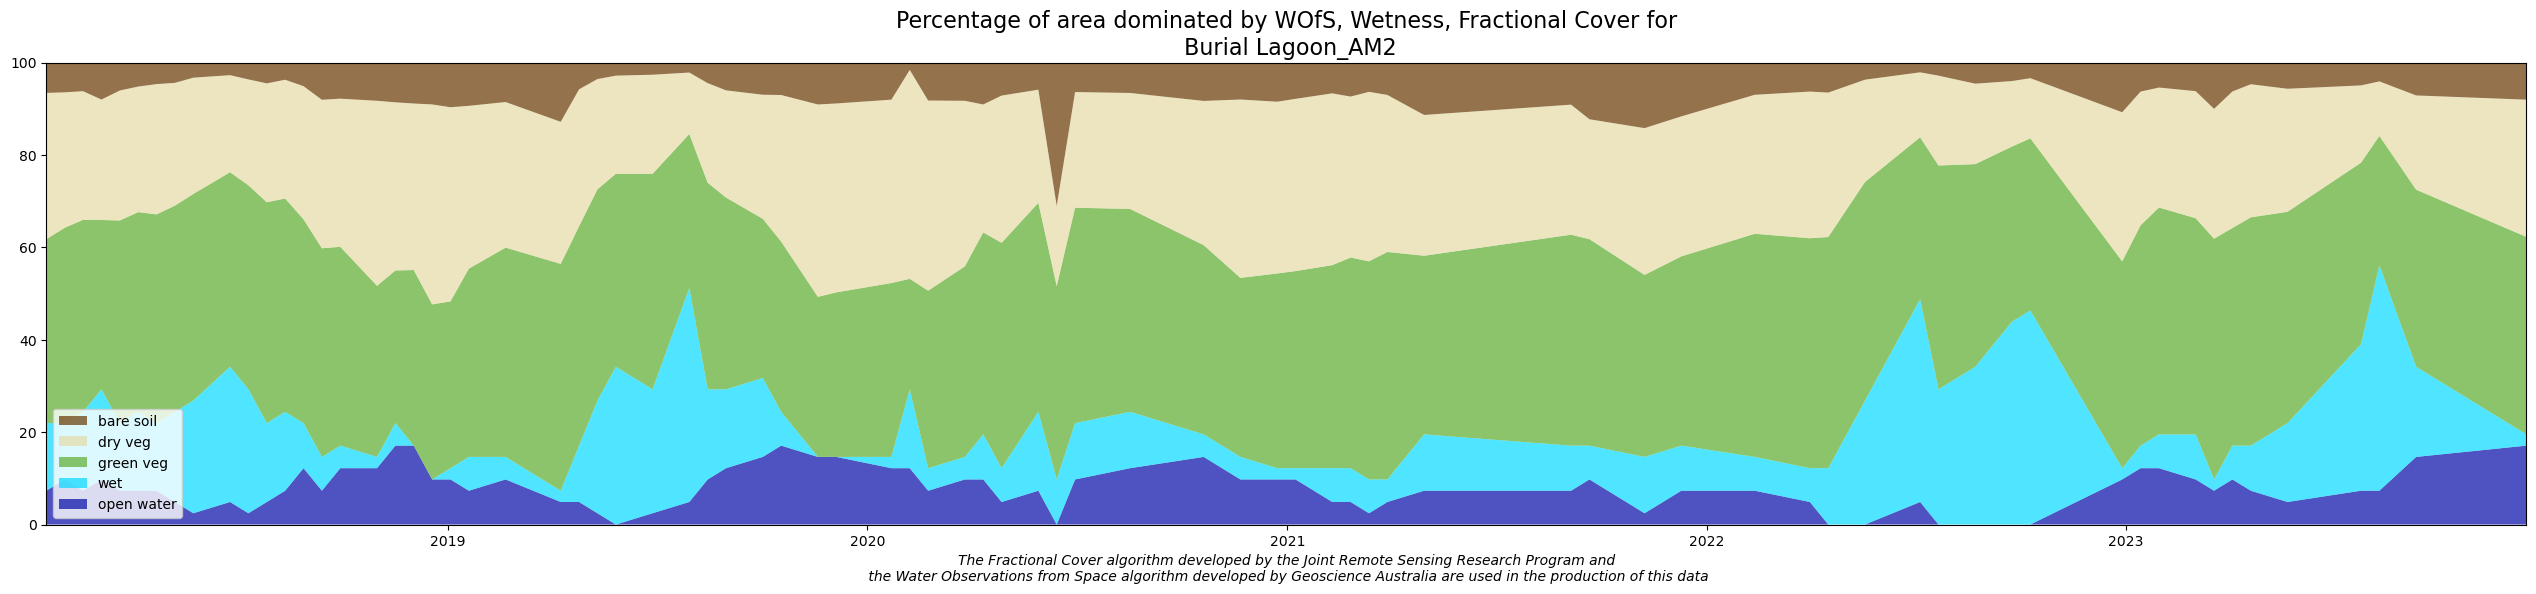

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 04:05:08,342 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2024-04-05 04:05:19,346 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2024-04-05 04:05:34,520 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


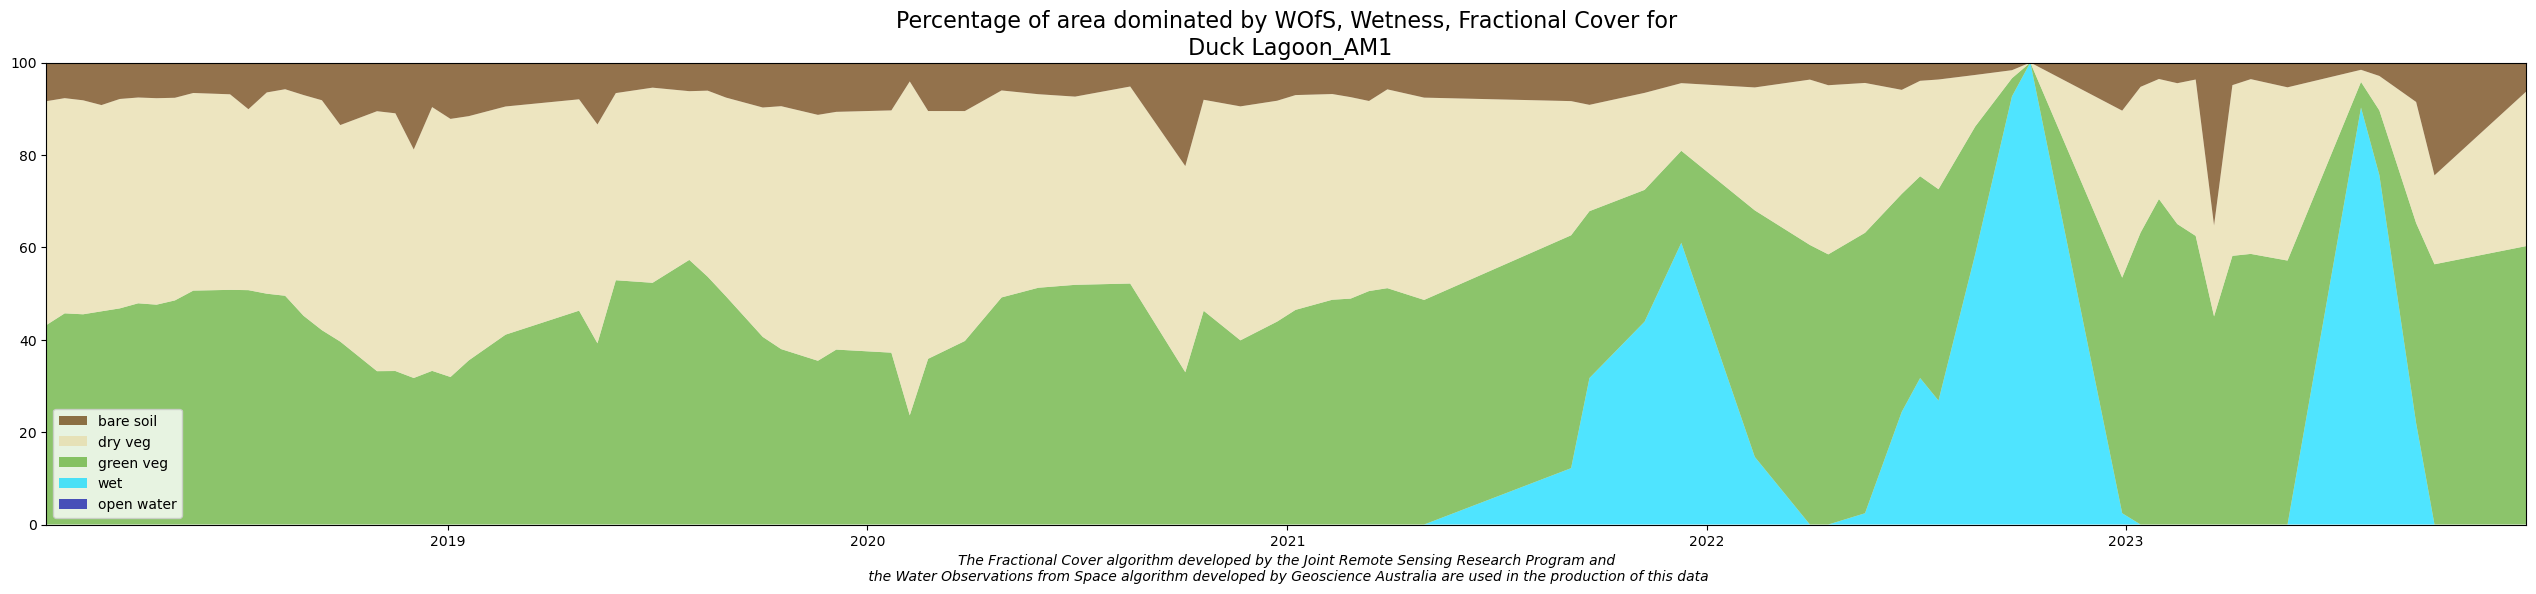

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 04:05:57,267 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2024-04-05 04:06:19,115 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2024-04-05 04:06:24,112 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2024-04-05 04:06:42,583 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


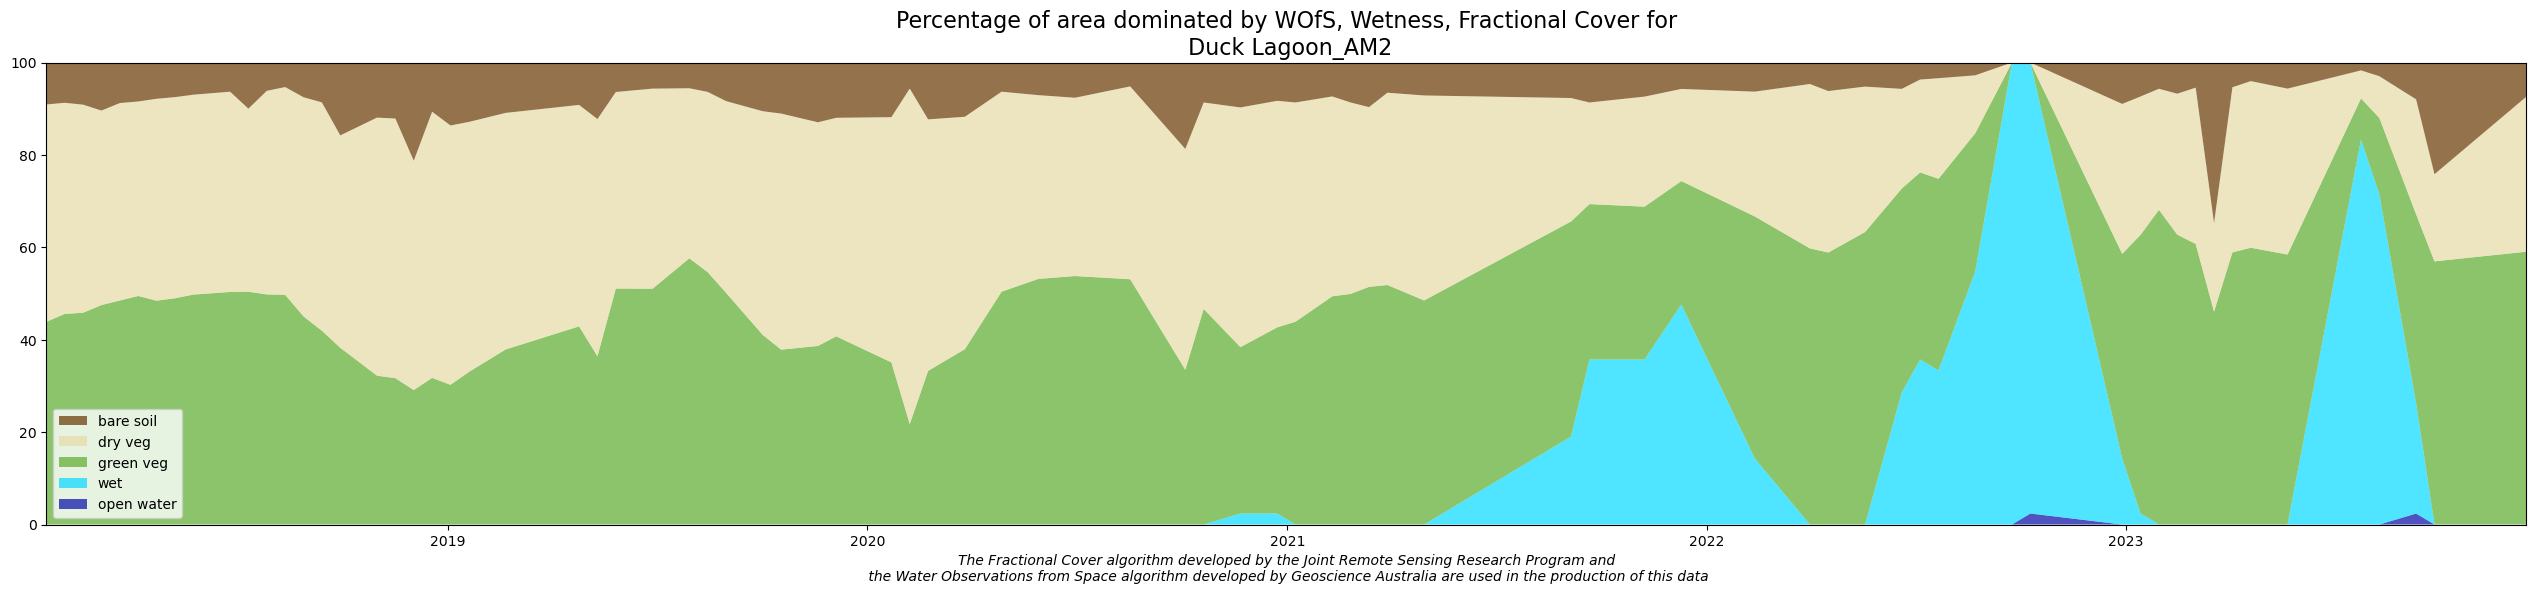

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 04:07:09,075 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2024-04-05 04:07:22,906 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2024-04-05 04:07:35,454 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


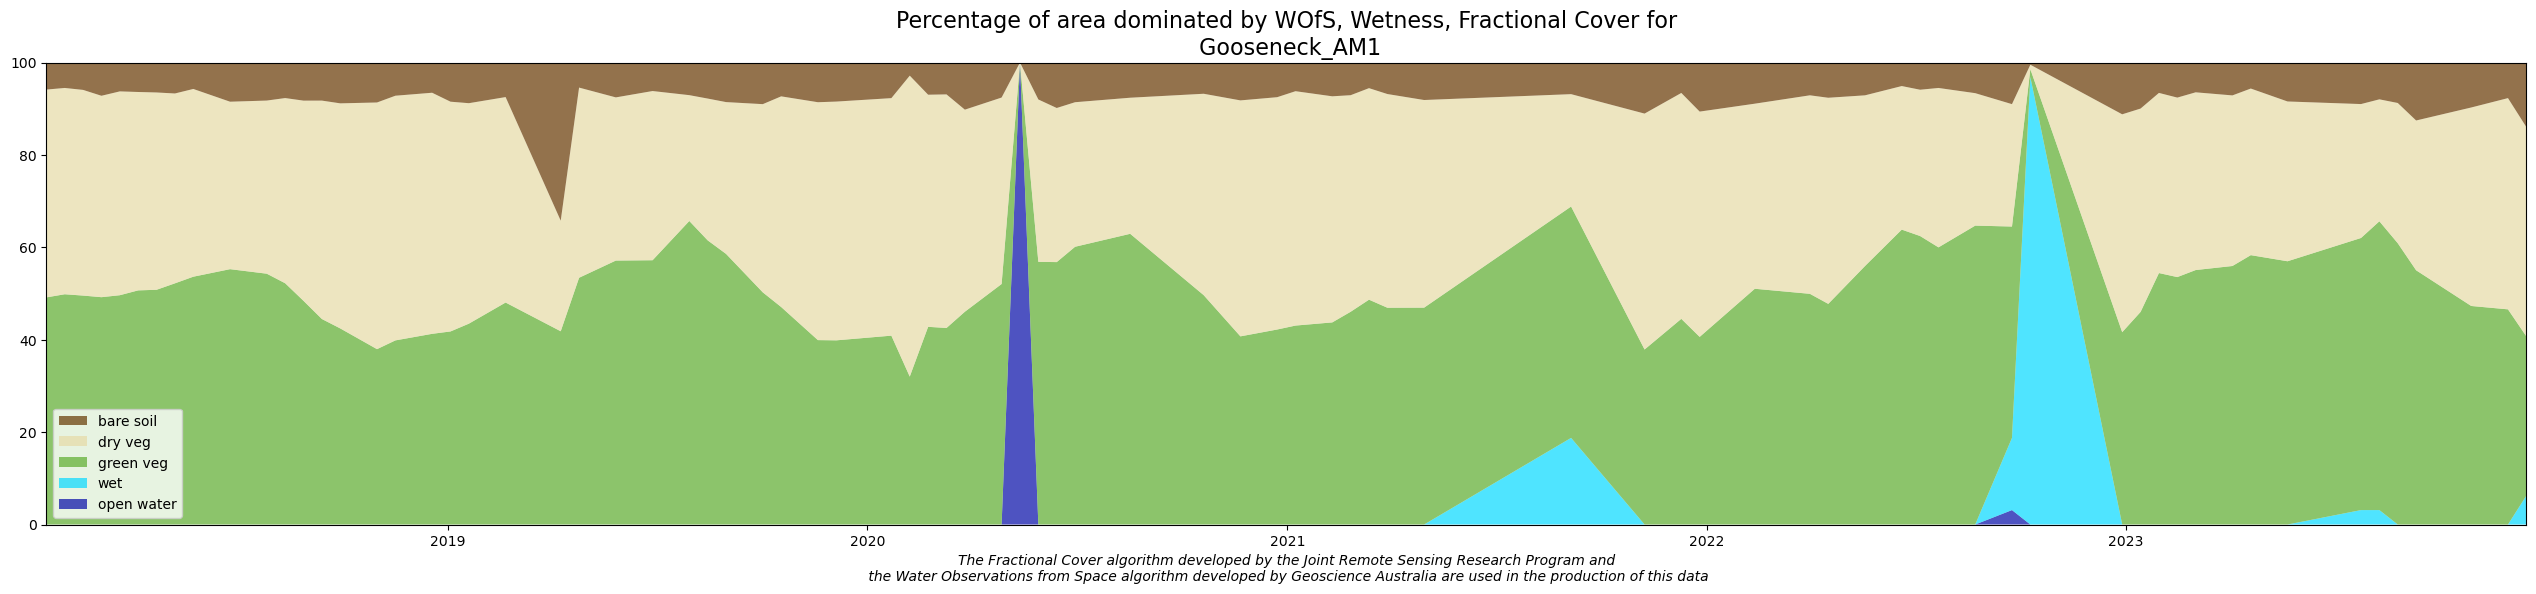

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 04:08:00,395 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2024-04-05 04:08:38,284 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2024-04-05 04:08:48,968 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2024-04-05 04:09:14,923 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


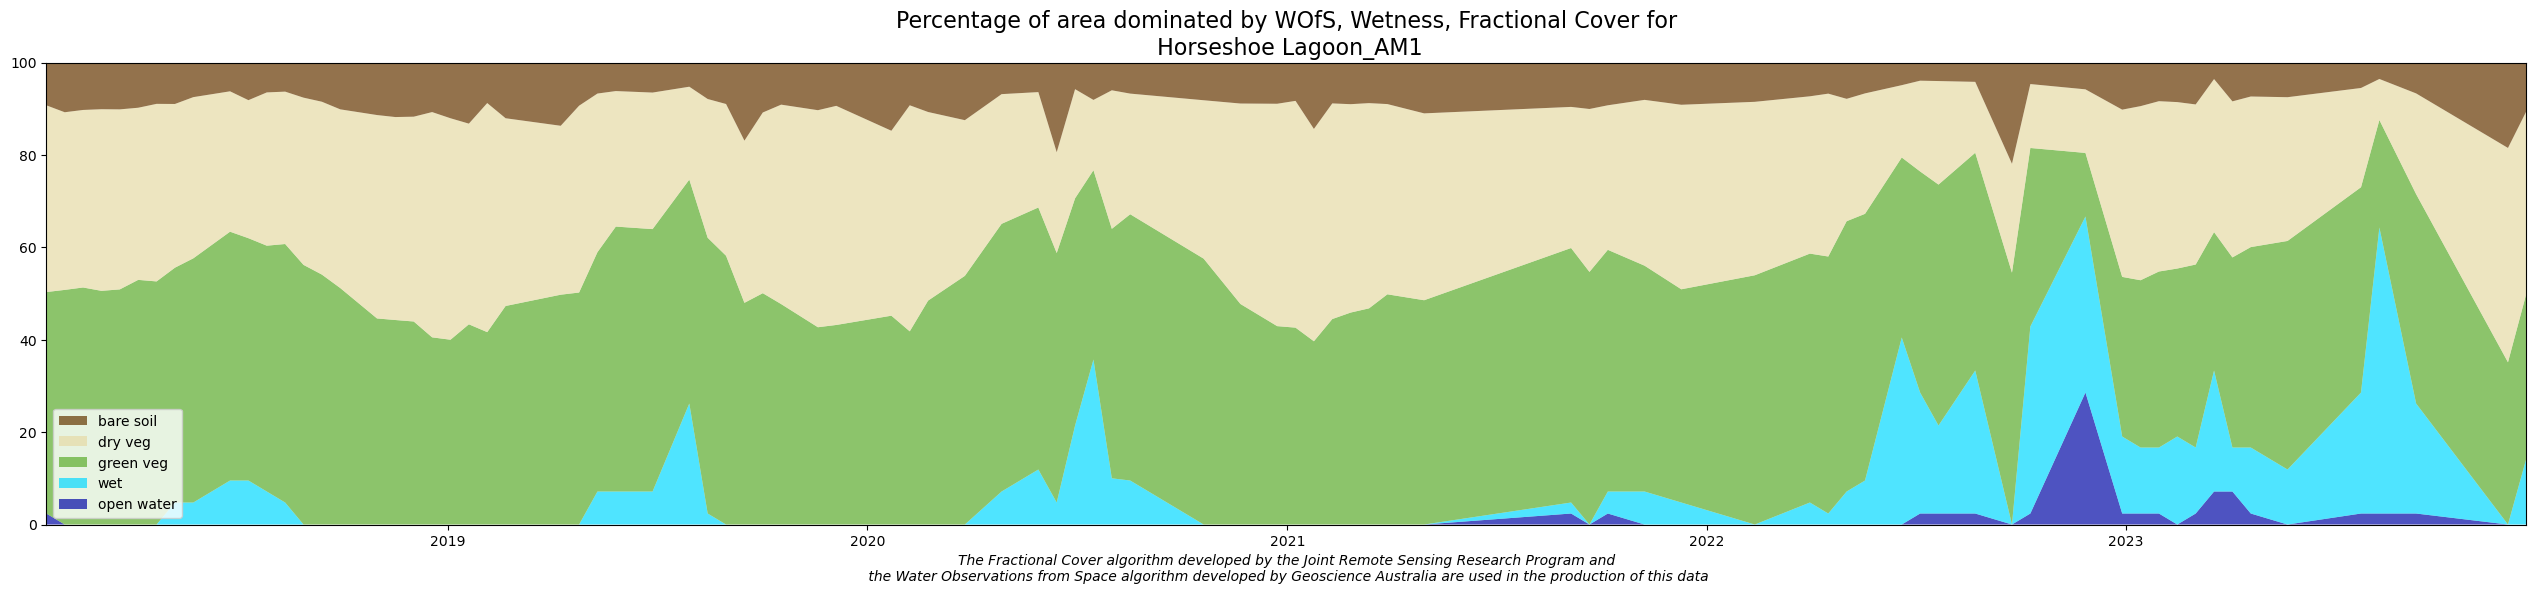

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 04:09:53,363 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2024-04-05 04:10:11,921 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2024-04-05 04:10:27,287 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


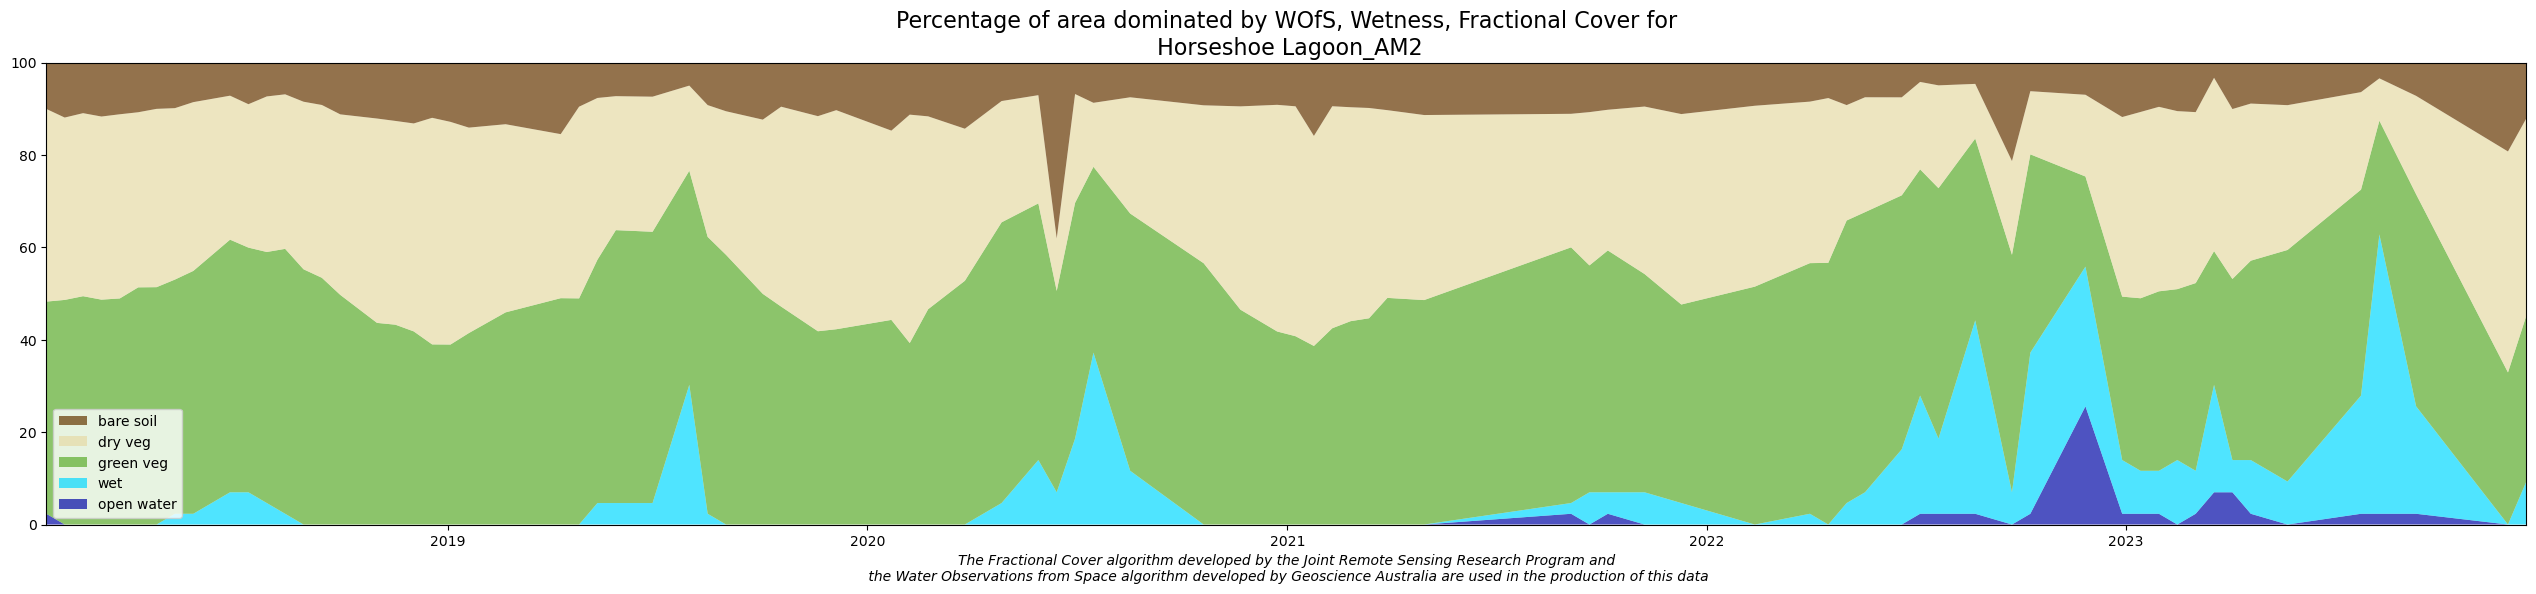

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 04:10:57,473 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2024-04-05 04:11:28,438 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2024-04-05 04:11:35,115 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2024-04-05 04:11:53,051 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


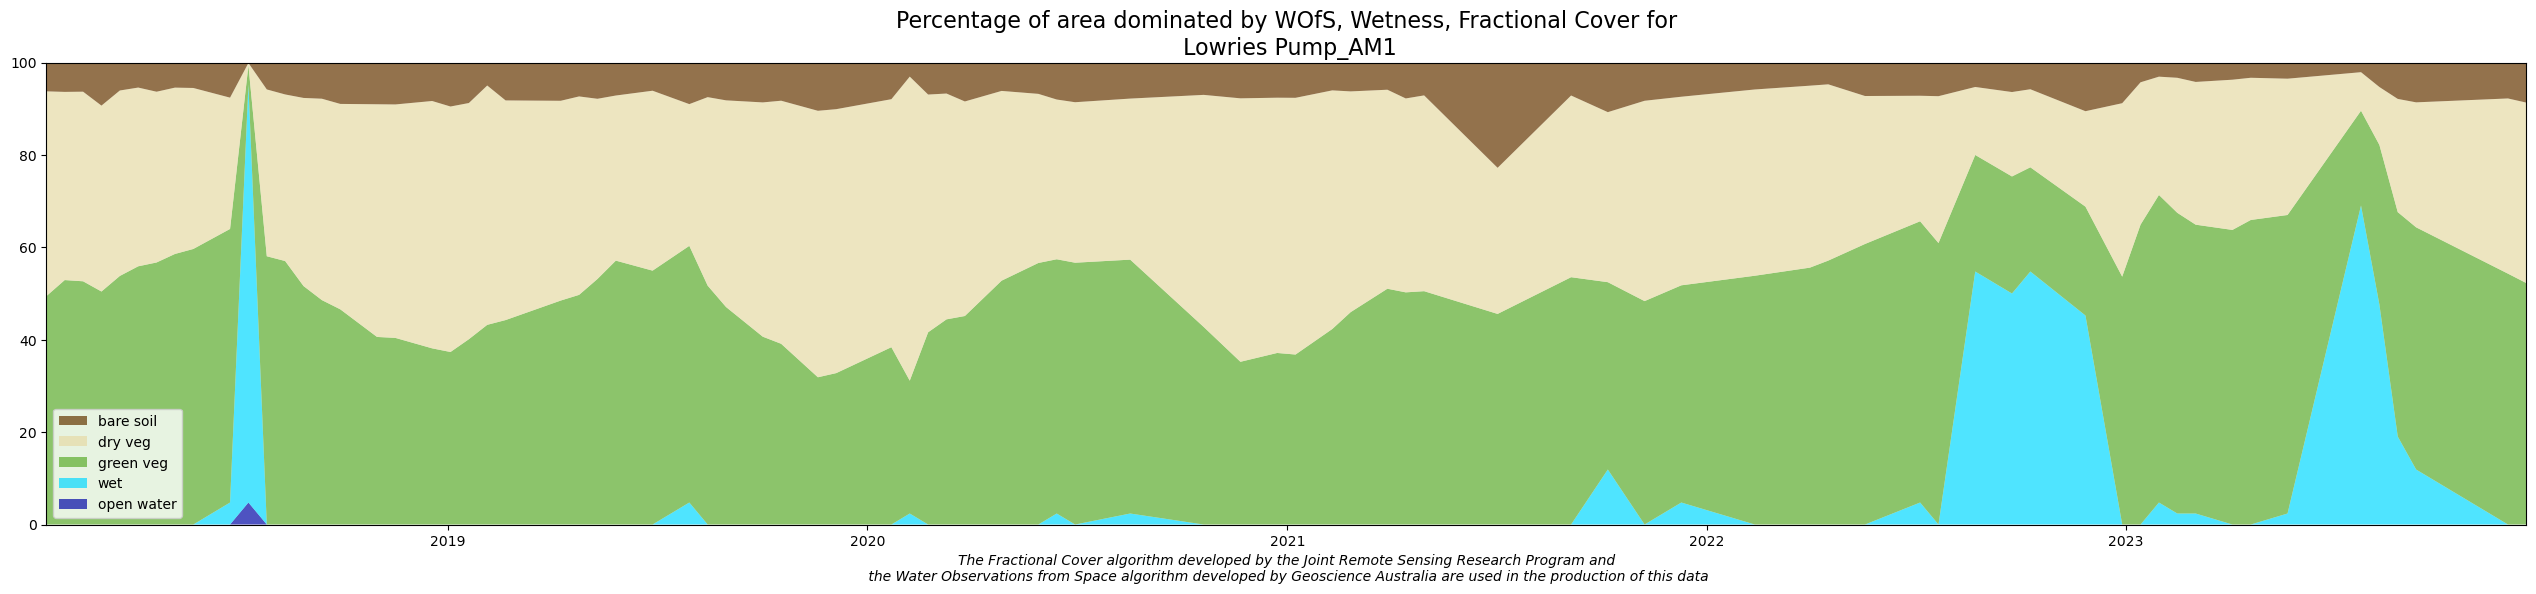

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 04:12:28,733 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2024-04-05 04:12:43,303 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2024-04-05 04:13:02,475 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


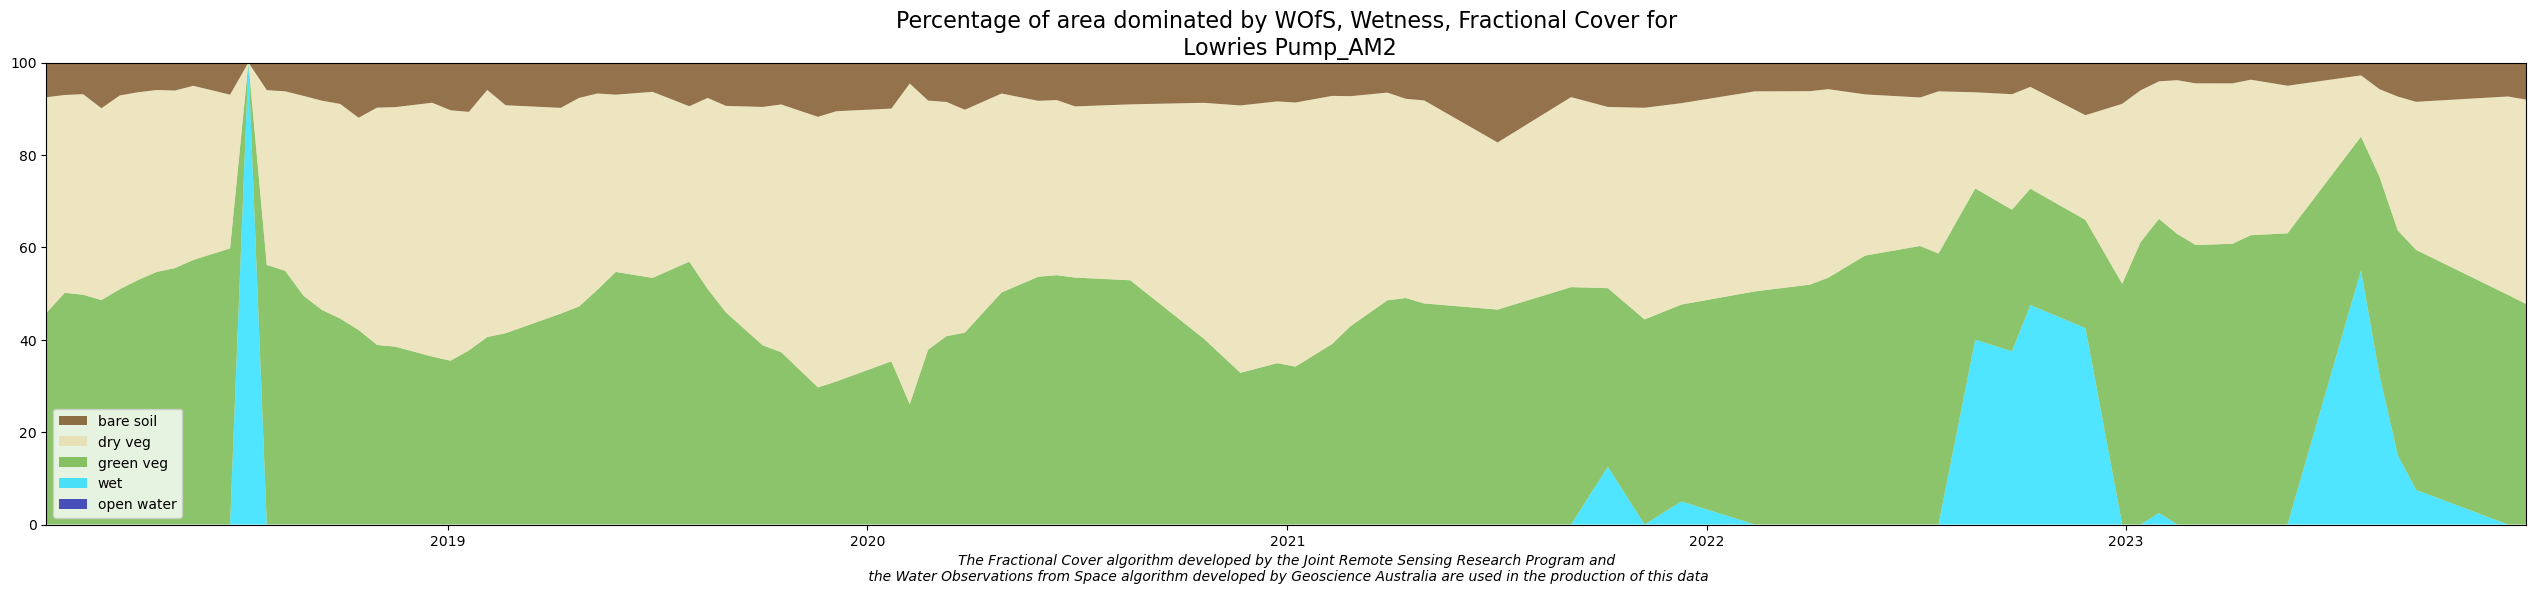

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 04:13:40,910 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2024-04-05 04:14:02,535 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2024-04-05 04:14:19,041 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


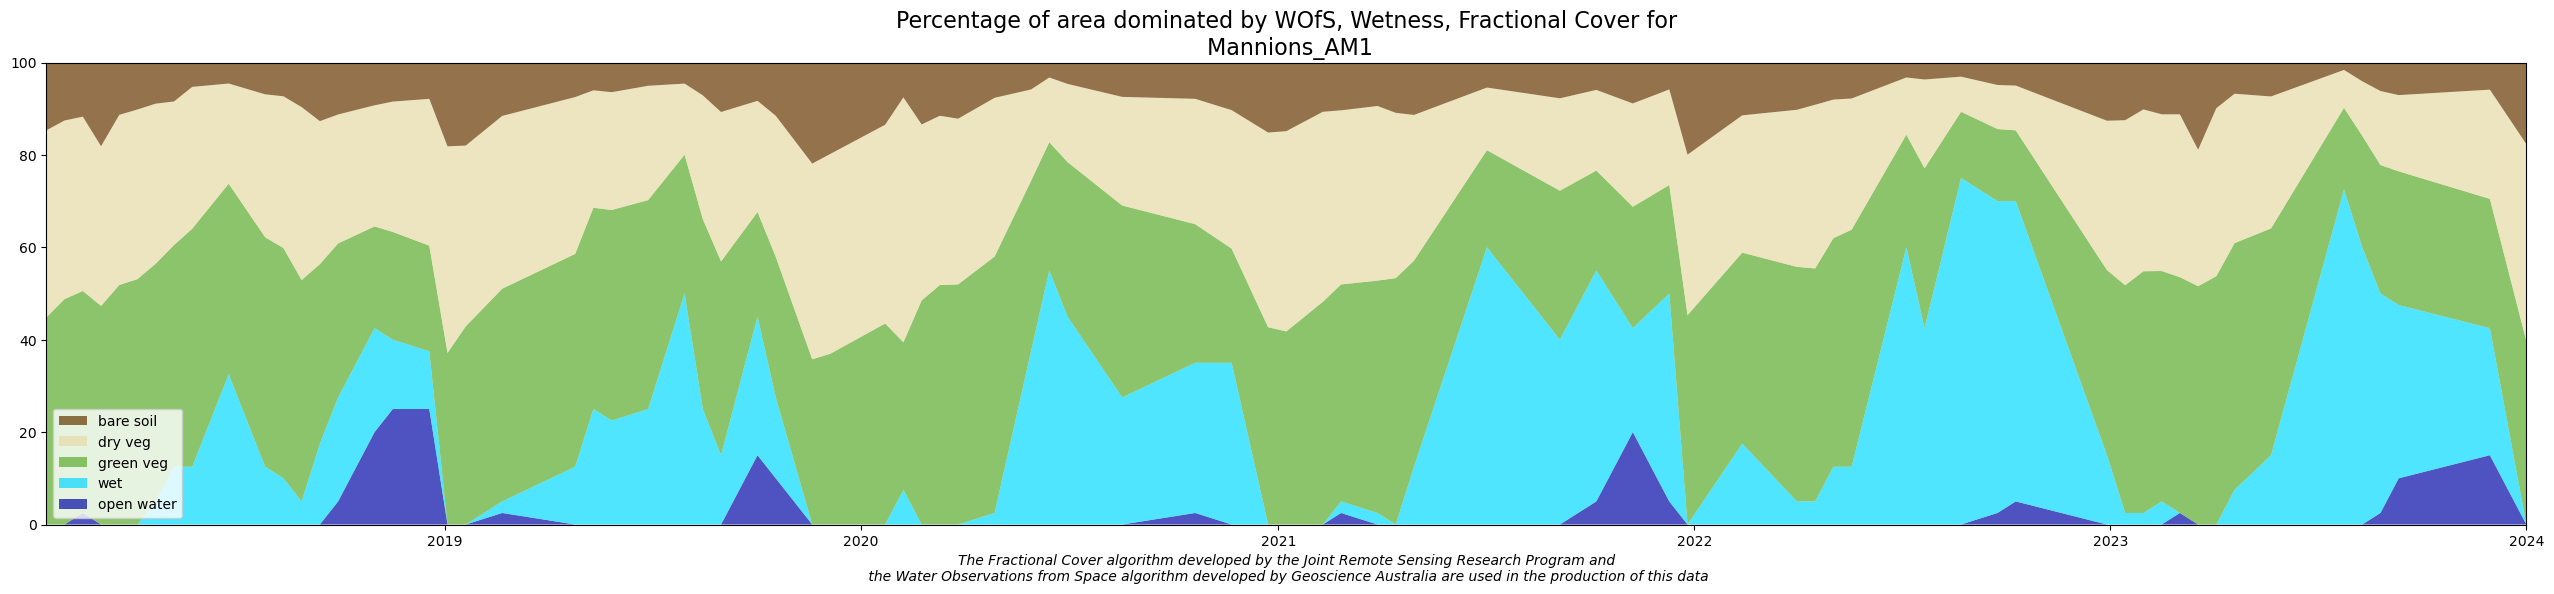

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 04:14:51,130 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2024-04-05 04:15:24,453 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2024-04-05 04:15:30,738 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2024-04-05 04:15:55,310 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


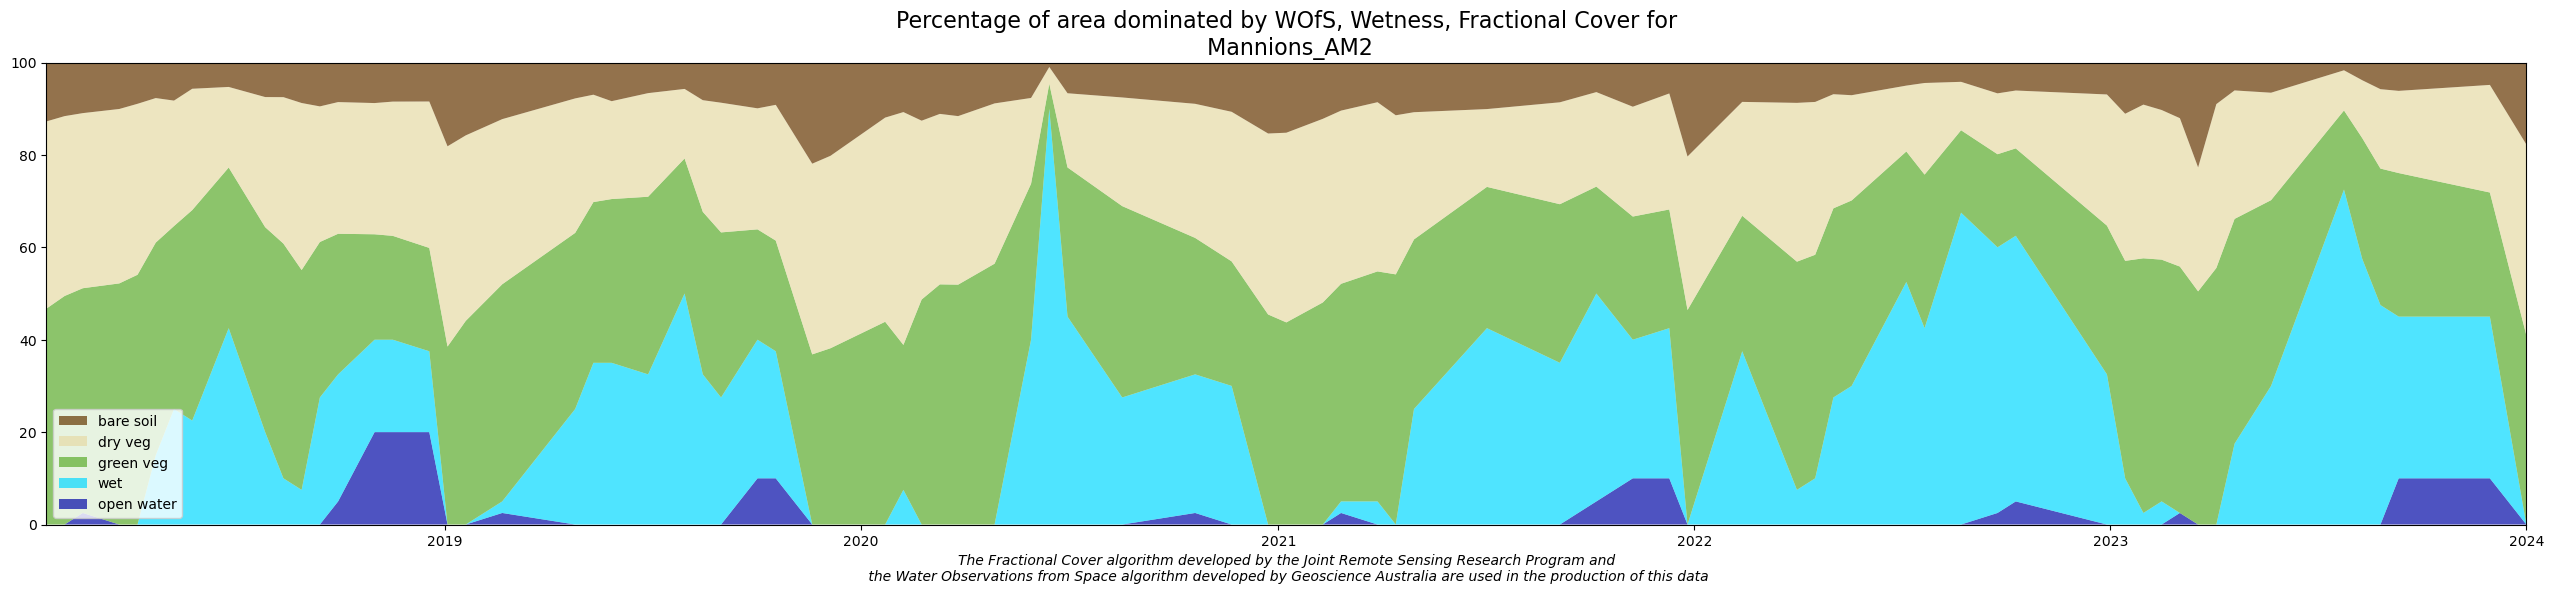

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 04:16:35,837 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2024-04-05 04:16:49,959 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2024-04-05 04:17:11,322 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


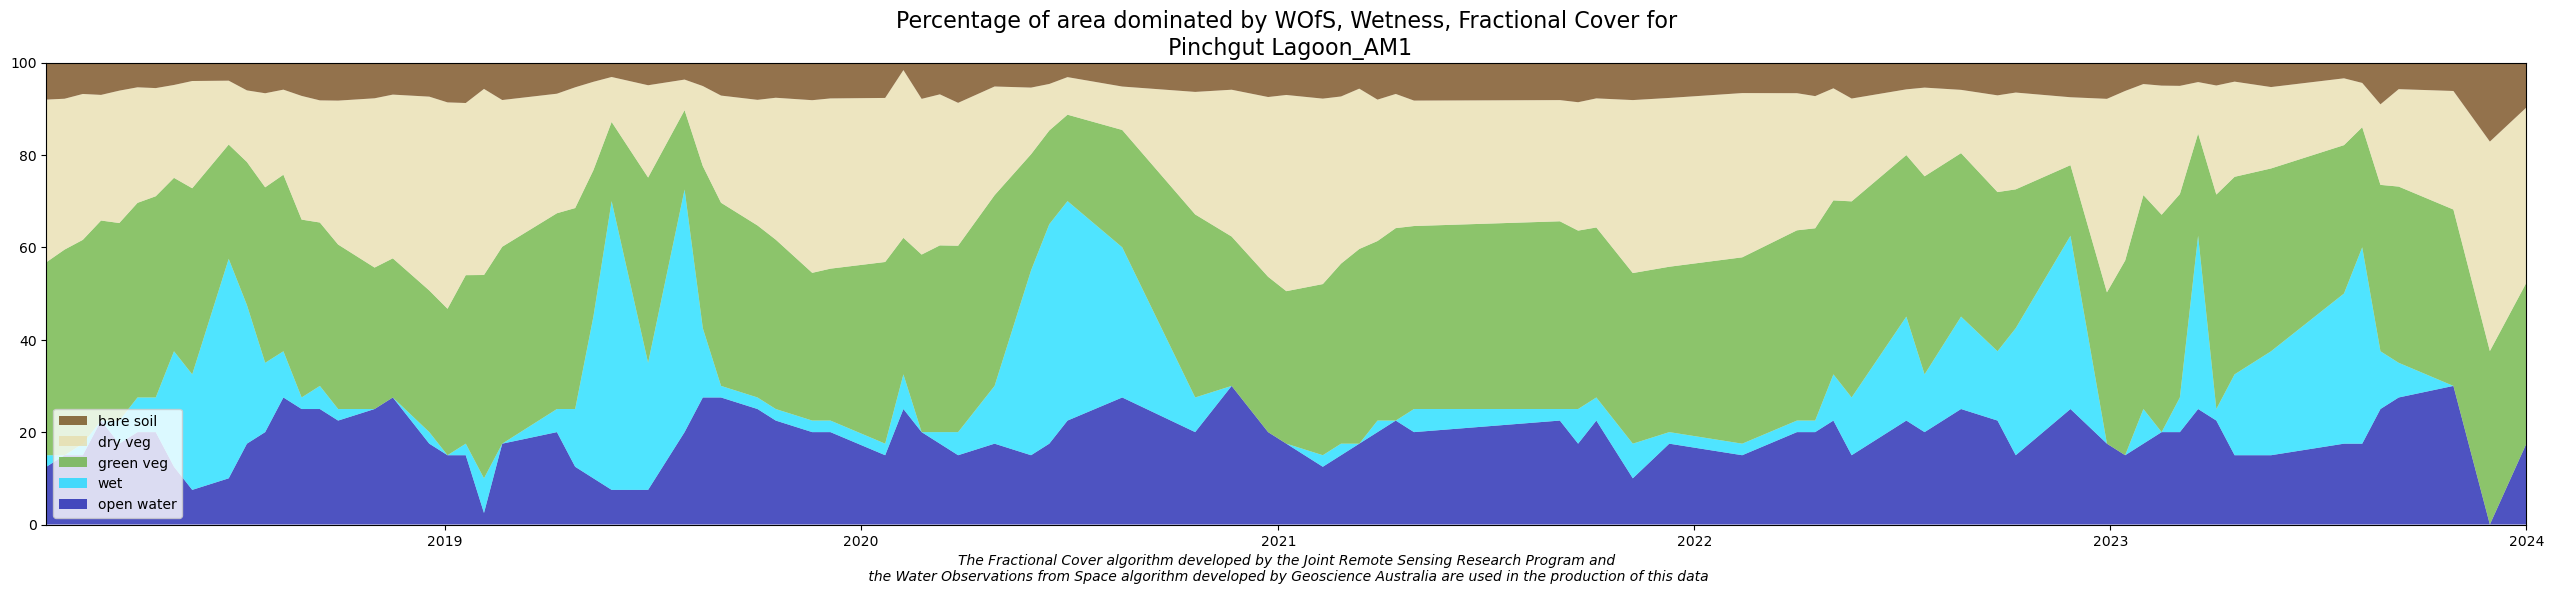

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 04:17:49,393 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2024-04-05 04:17:55,580 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2024-04-05 04:18:18,425 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


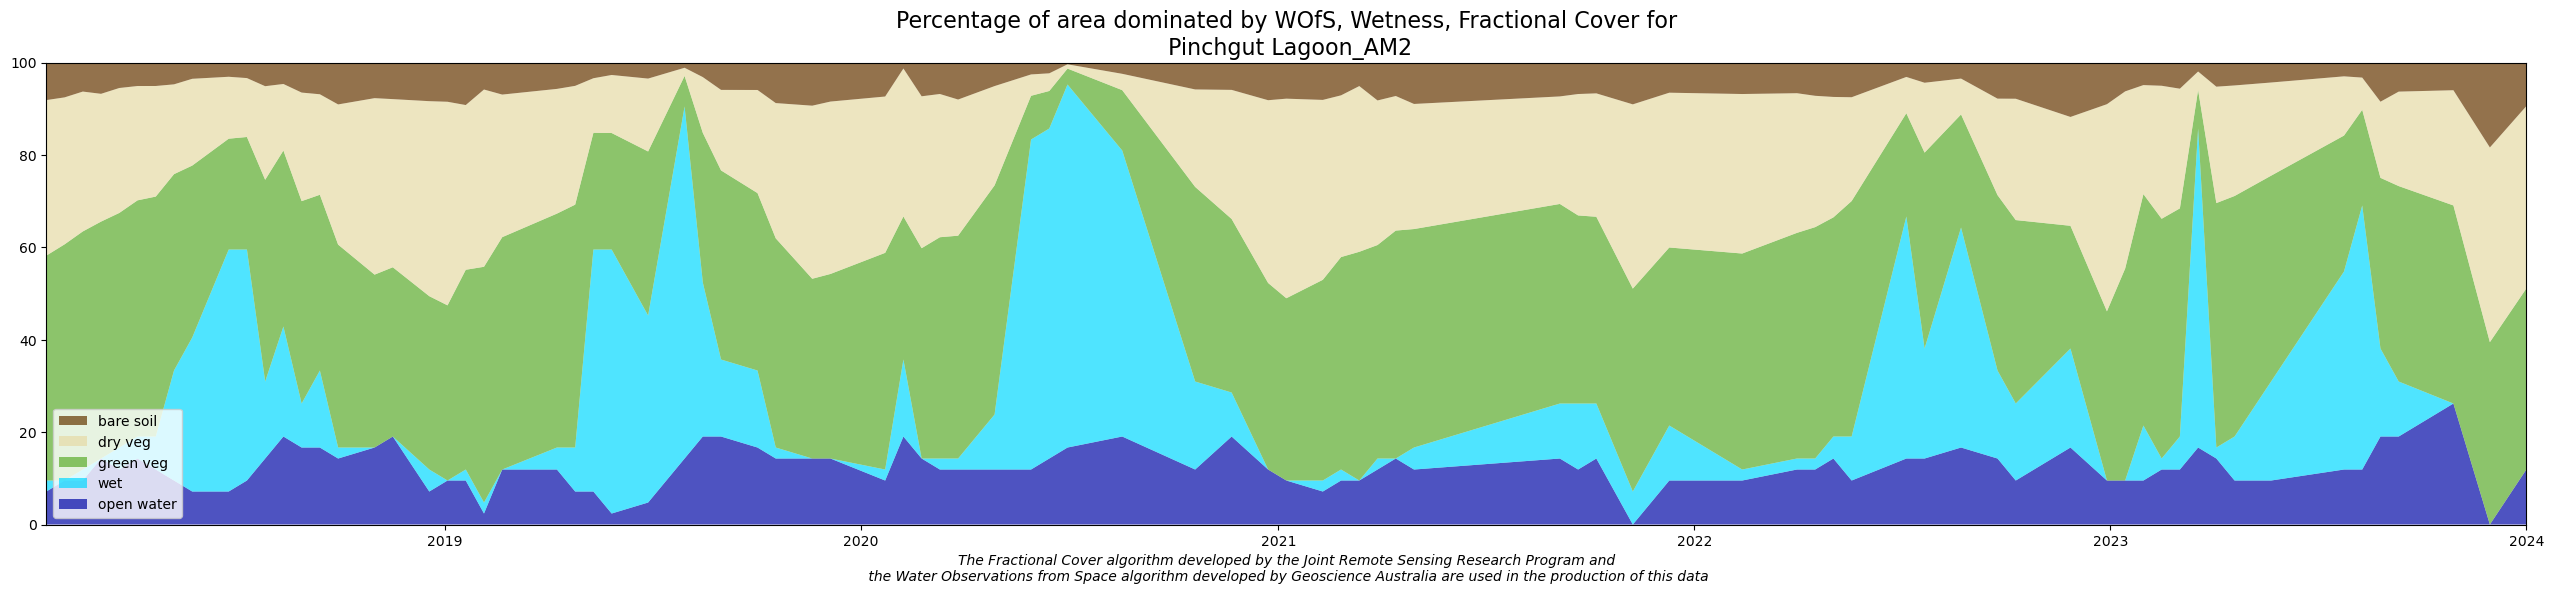

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 04:18:52,824 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2024-04-05 04:19:02,024 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


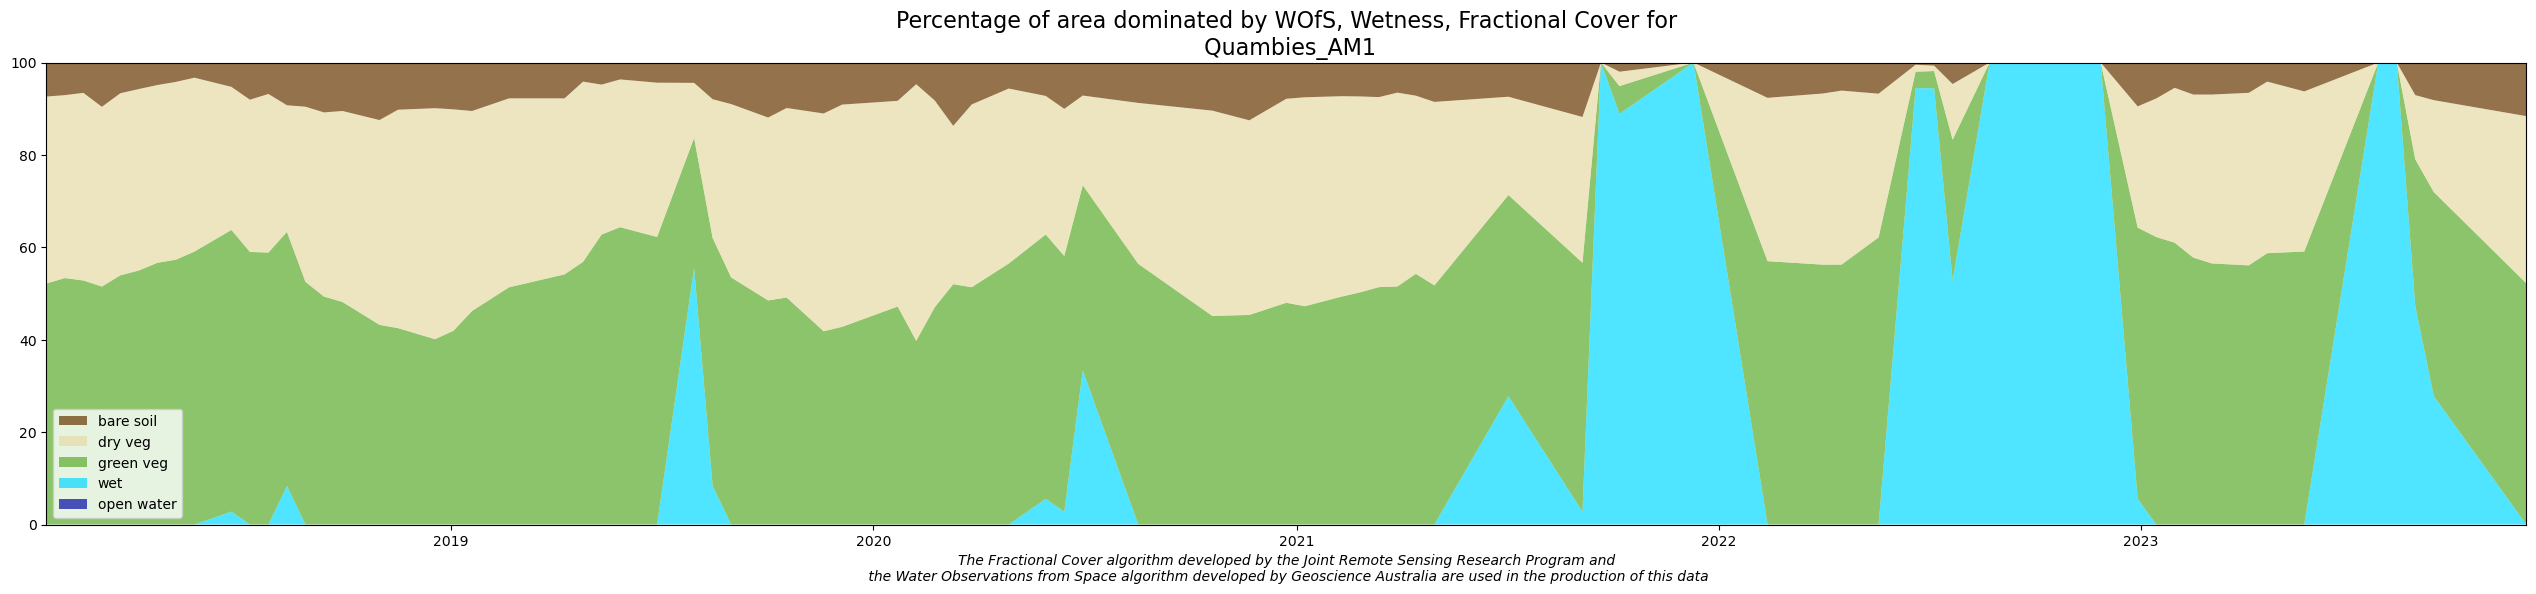

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 04:19:27,759 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2024-04-05 04:19:58,433 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2024-04-05 04:20:04,726 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


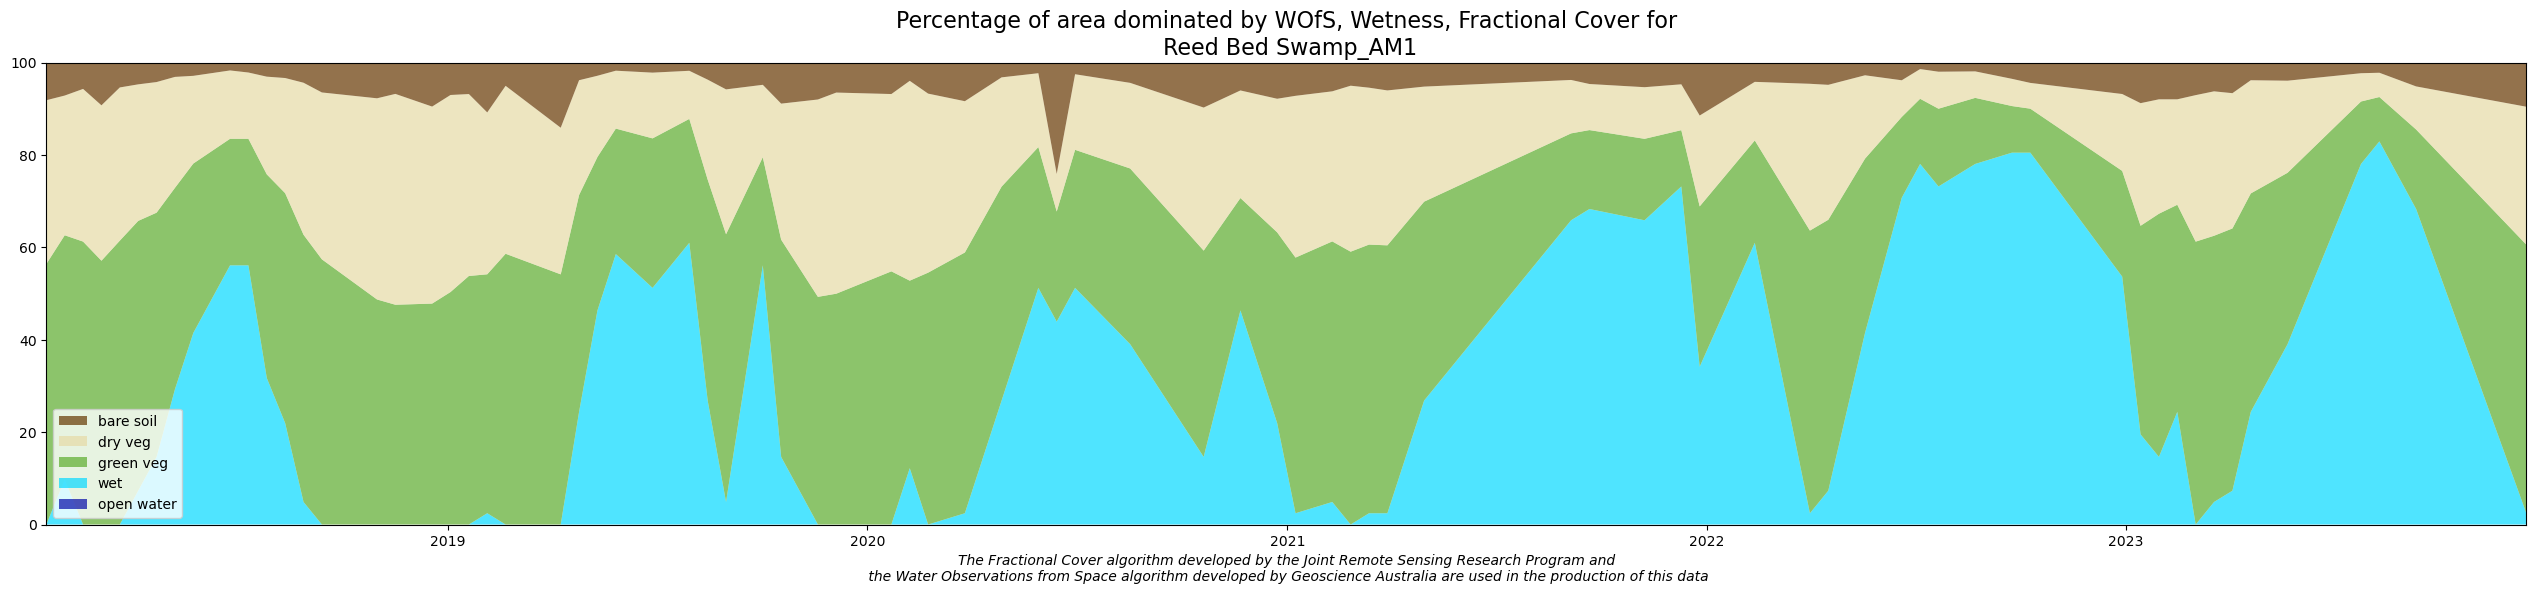

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 04:20:31,239 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2024-04-05 04:20:58,847 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2024-04-05 04:21:05,207 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


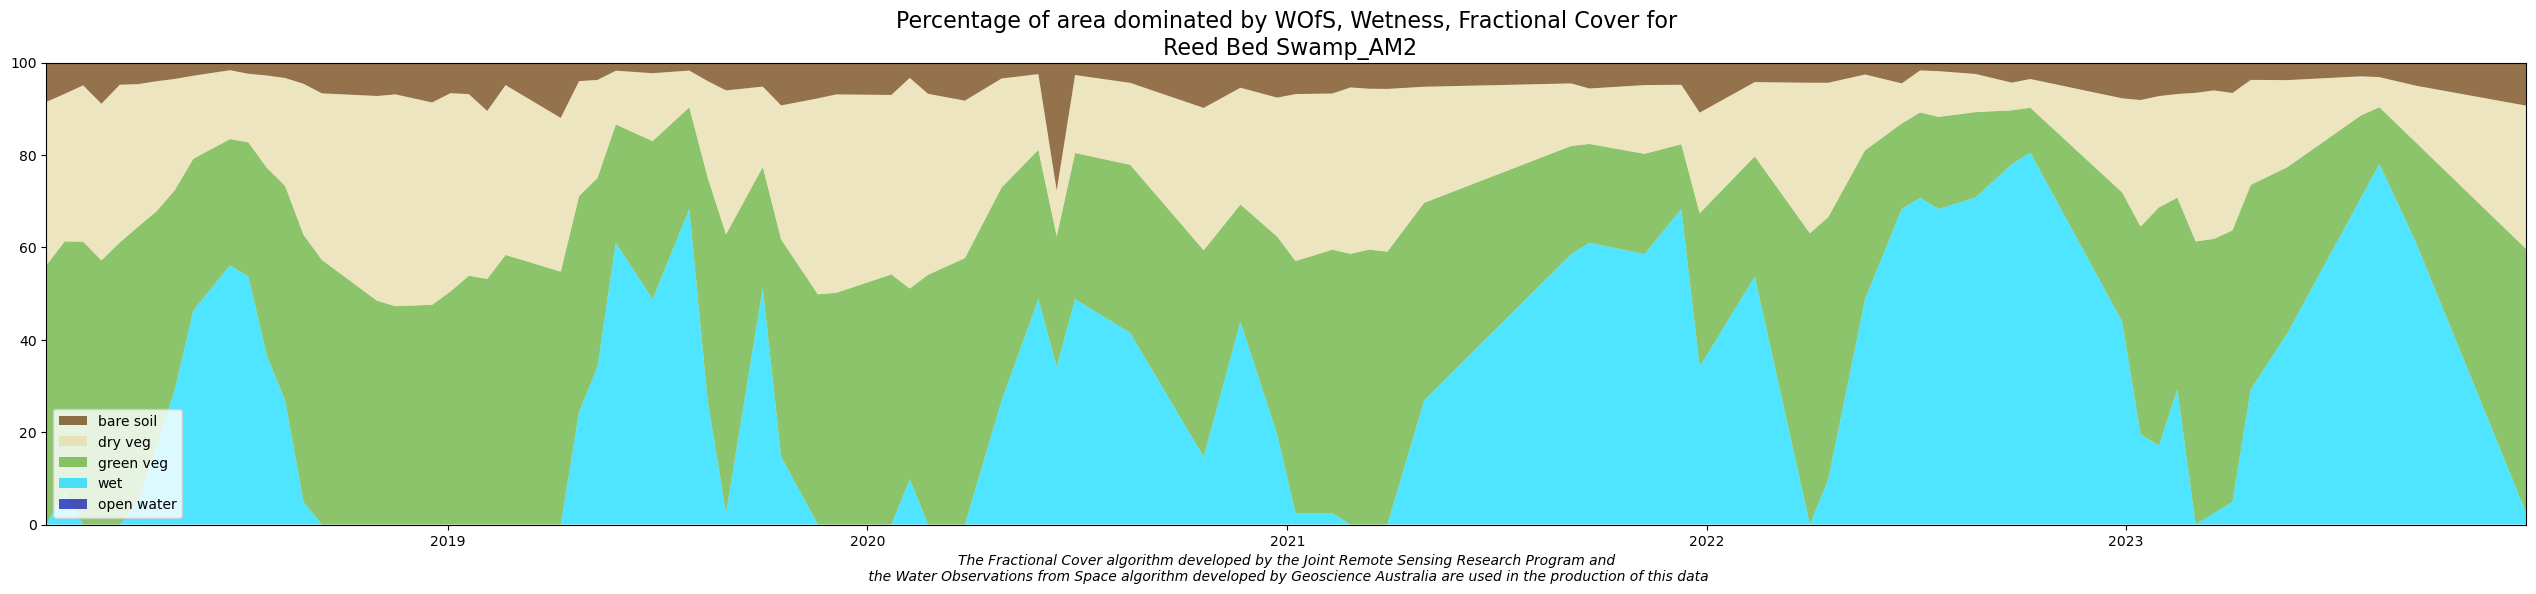

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 178 time steps as a dask array


2024-04-05 04:21:38,523 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2024-04-05 04:22:37,316 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2024-04-05 04:22:56,376 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2024-04-05 04:23:27,341 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


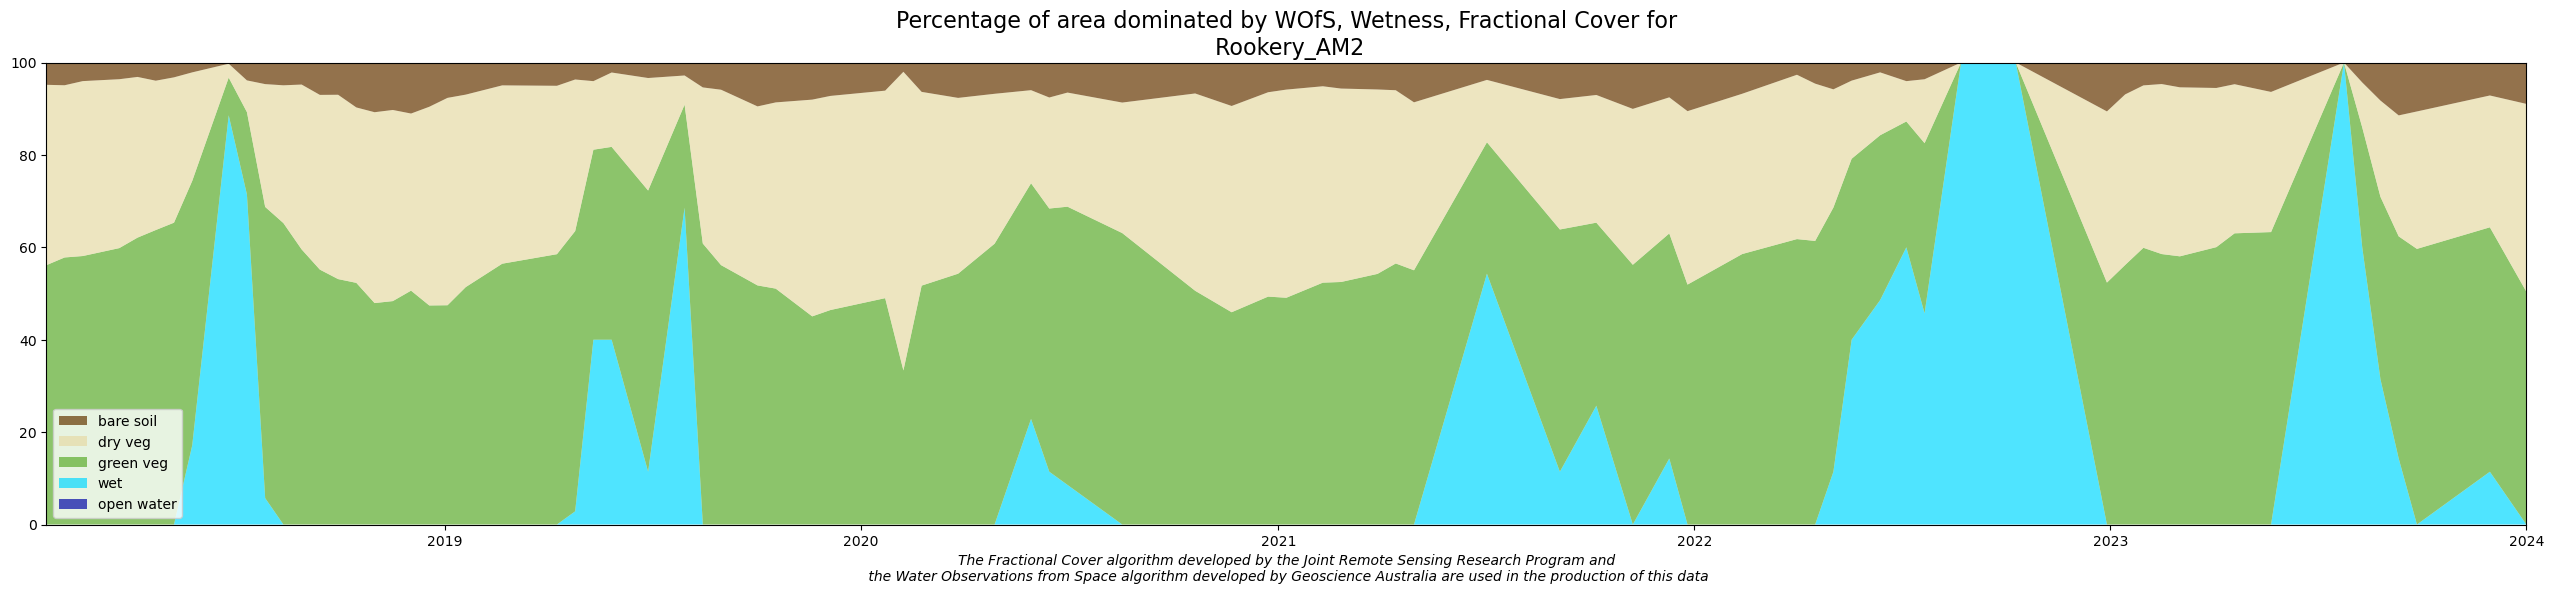

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 04:24:15,170 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2024-04-05 04:24:44,910 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2024-04-05 04:25:06,073 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


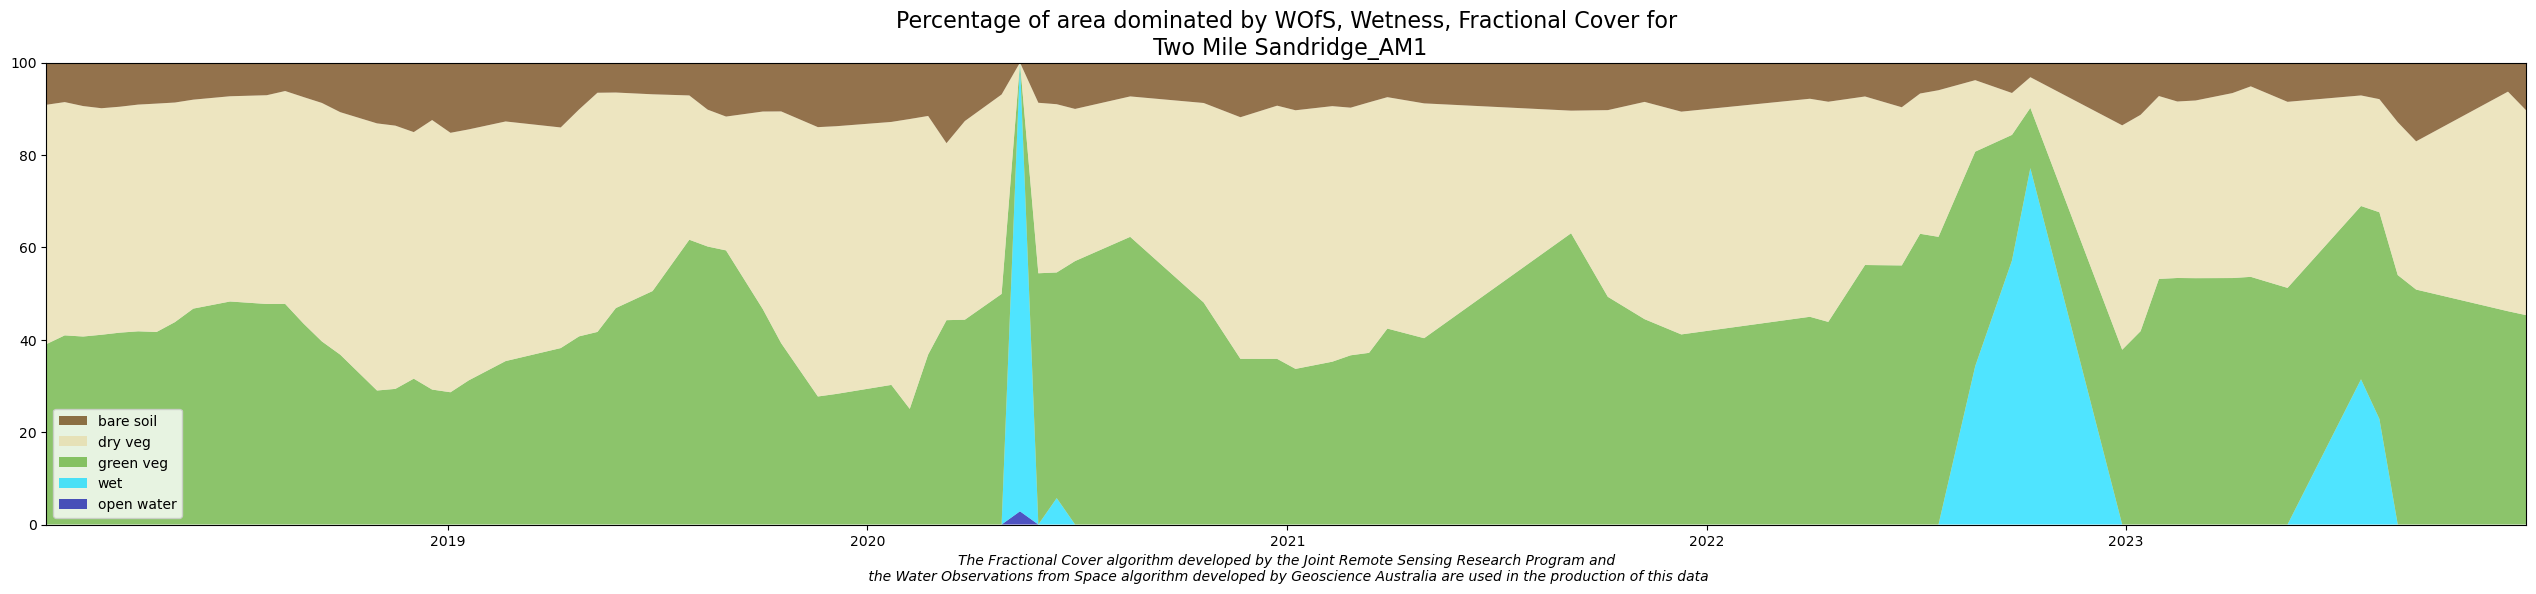

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 04:25:45,660 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2024-04-05 04:26:04,330 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2024-04-05 04:26:31,794 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


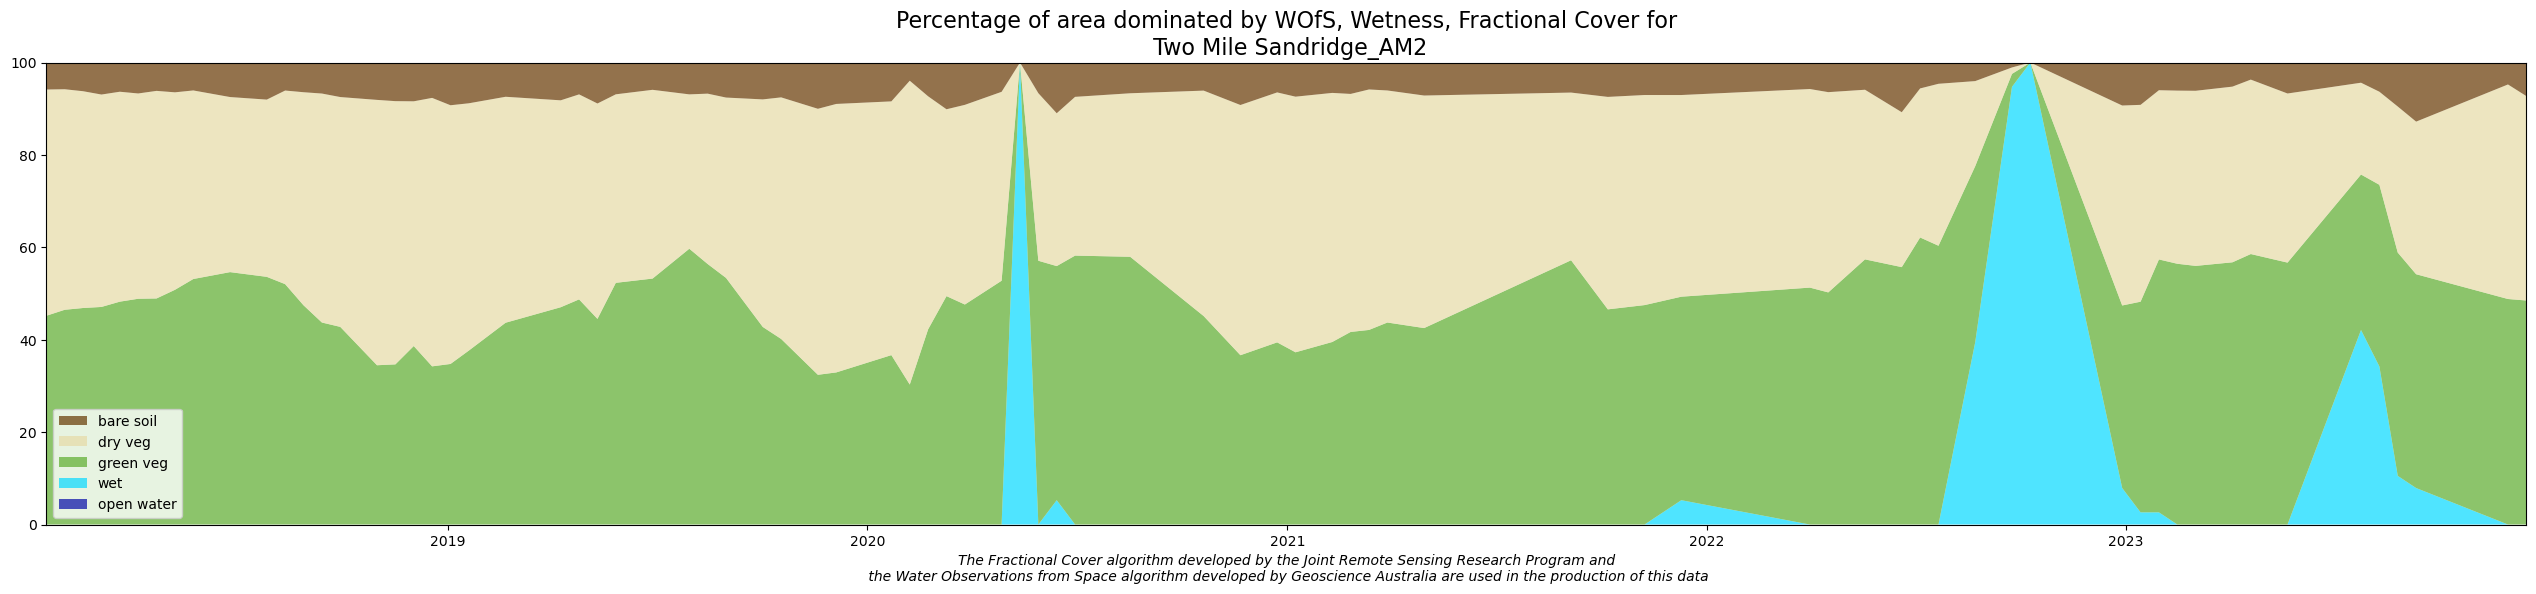

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 04:27:11,550 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2024-04-05 04:27:26,331 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


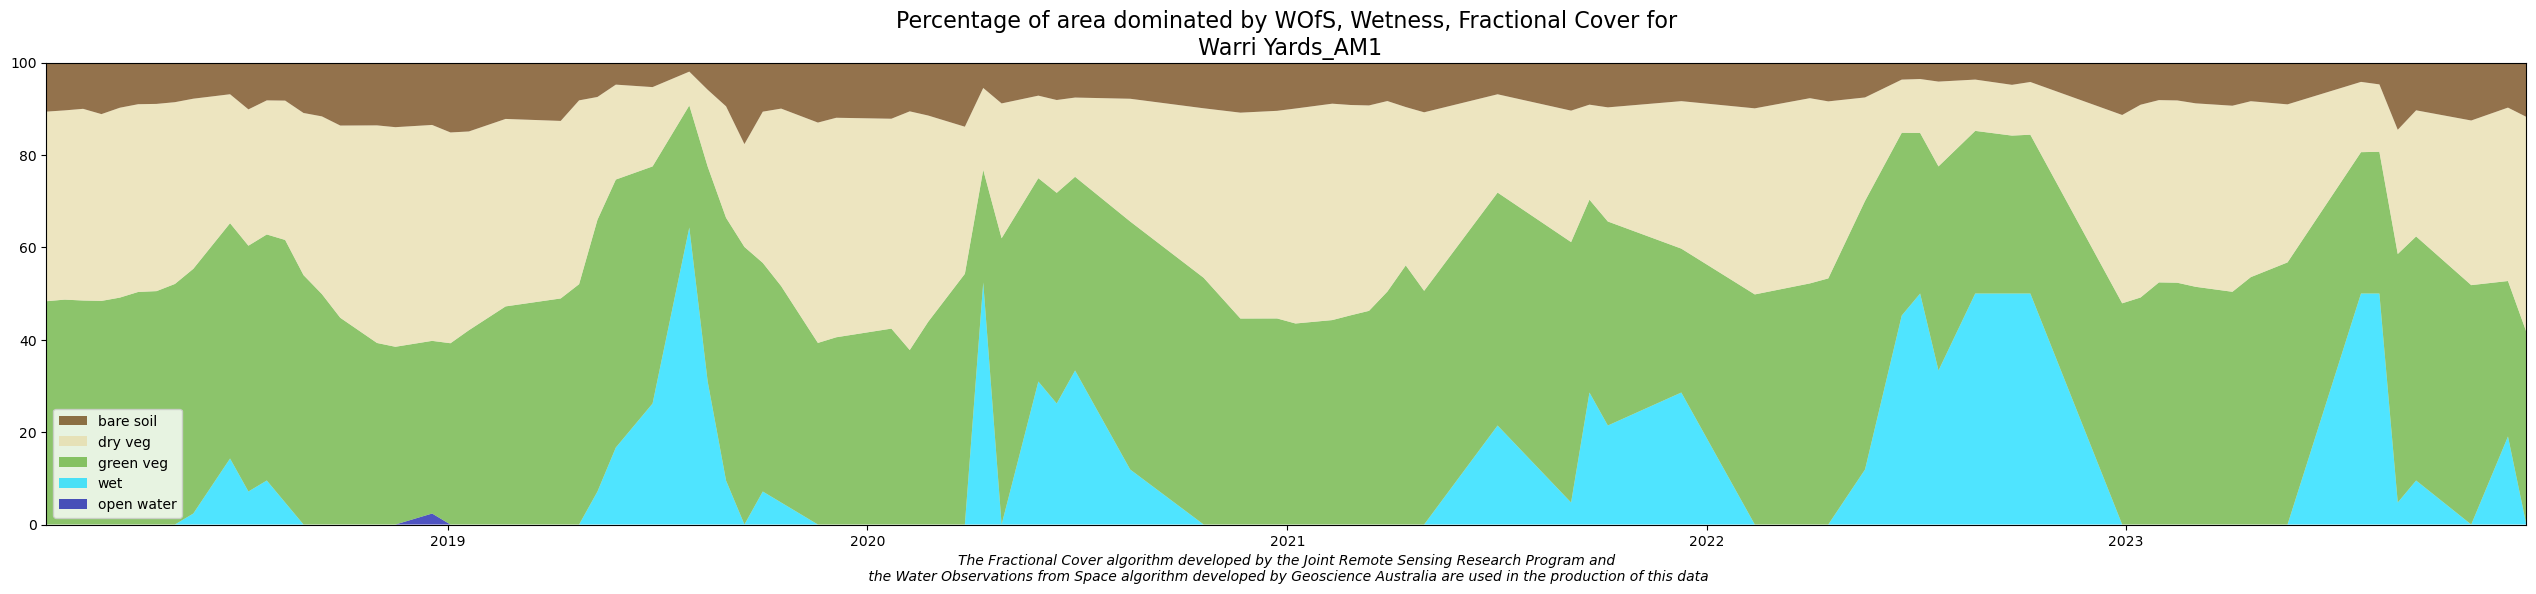

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 04:27:58,492 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2024-04-05 04:28:18,691 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2024-04-05 04:28:42,356 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


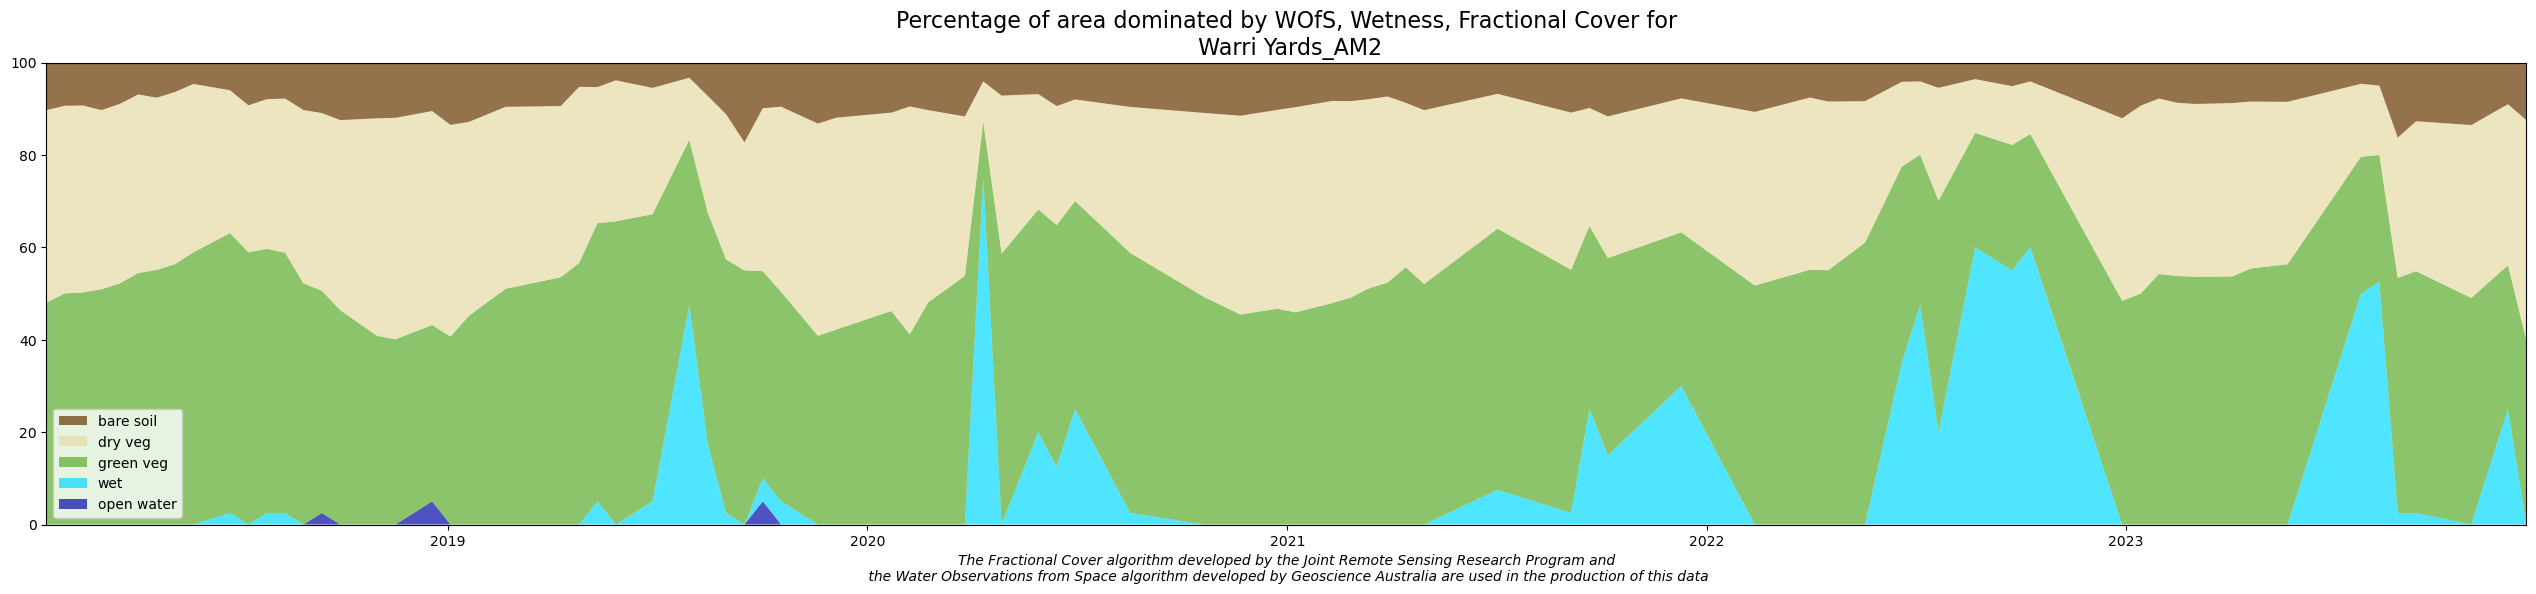

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 04:29:25,052 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2024-04-05 04:29:38,901 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


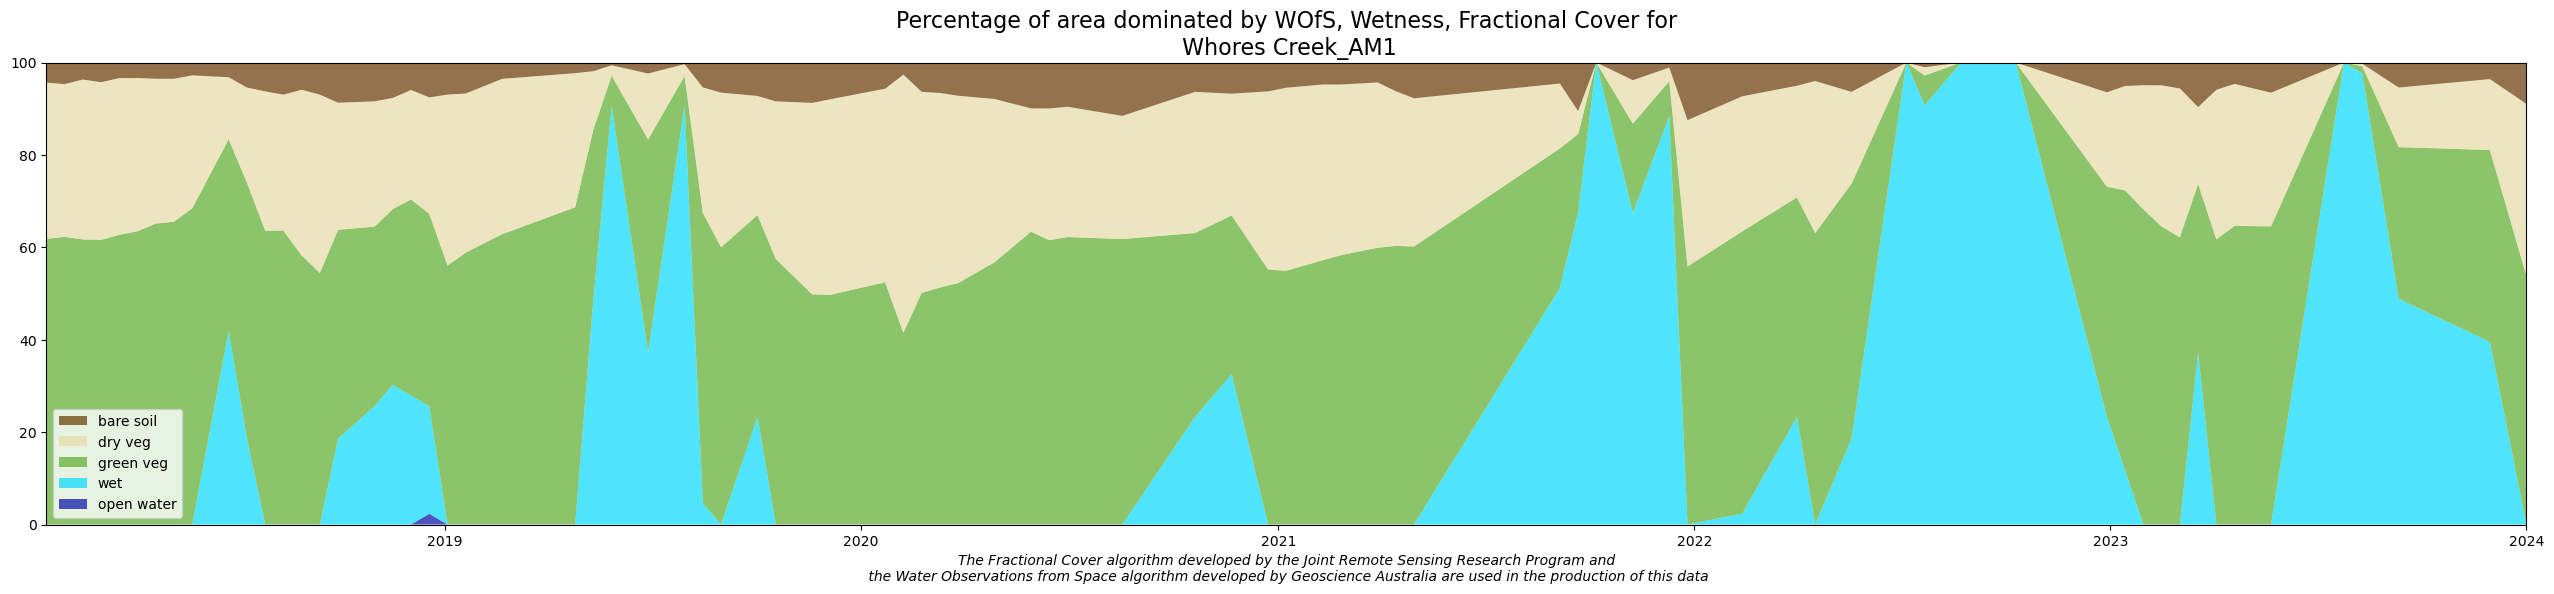

Finding datasets
    ga_ls8c_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls5t_ard_3
Applying fmask pixel quality/cloud mask
Returning 136 time steps as a dask array


2024-04-05 04:30:12,324 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2024-04-05 04:30:32,834 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2024-04-05 04:30:57,471 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


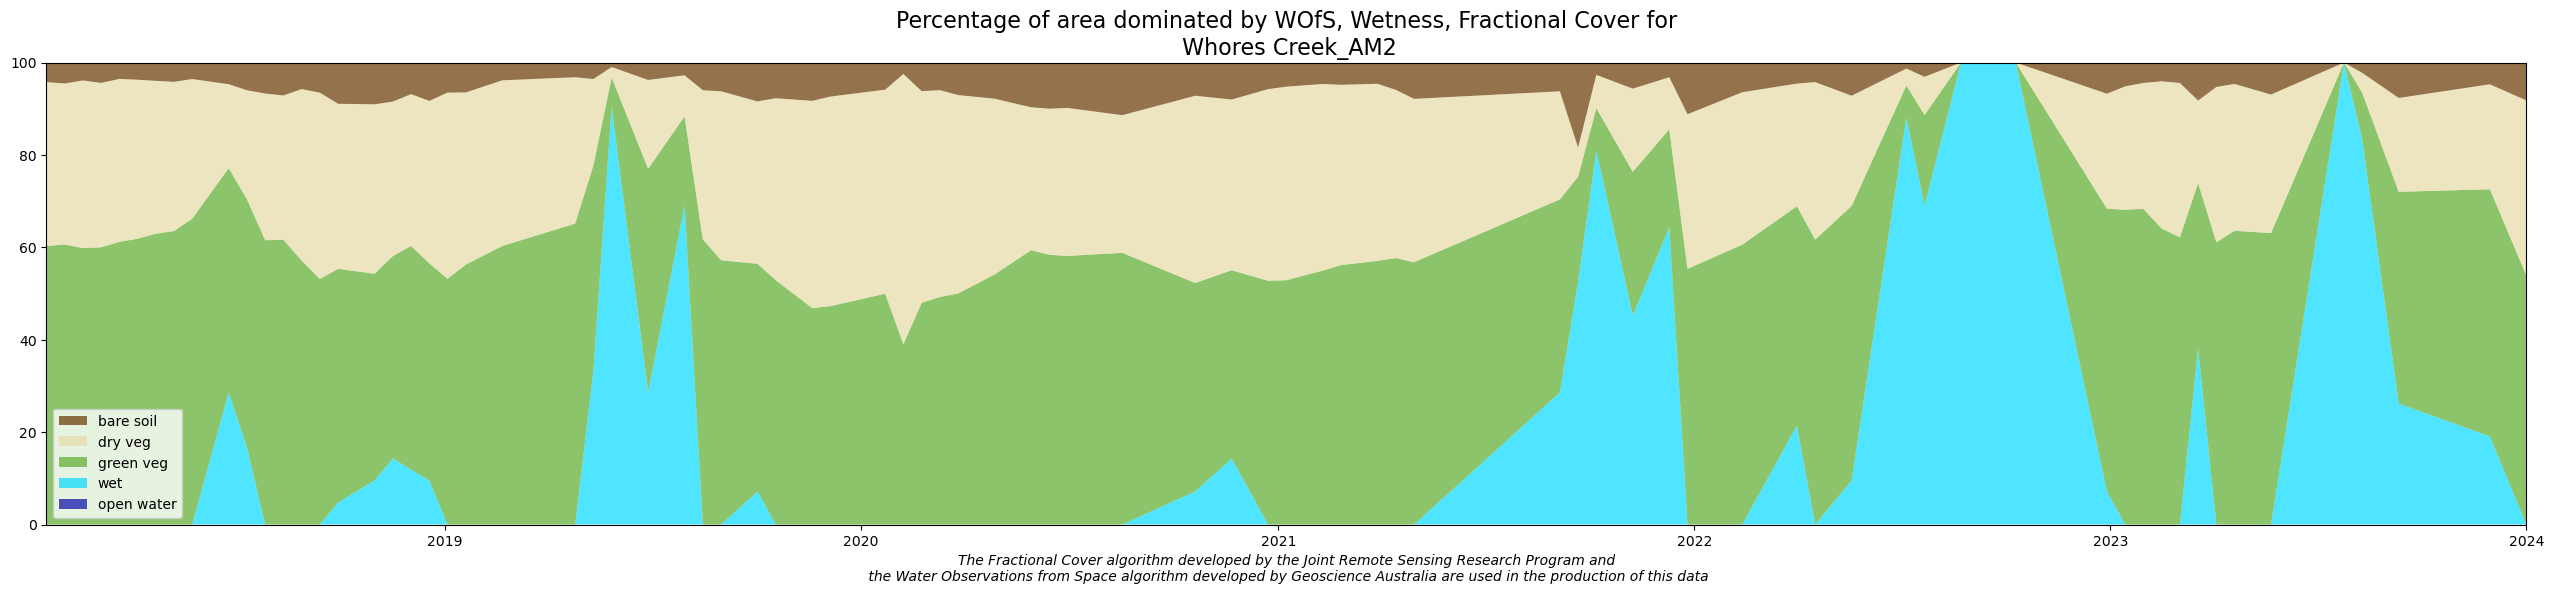

In [6]:
# This cell loads and plots the wetlands polygon. If no output, check your polygon
poly = gpd.read_file("site_metadata_sf/site_metadata_sf.shp")
for index, wetland in poly.iterrows():
    # get wetland point geodata
    # Specifying coordinate reference system of the polygon.
    gpgon = datacube.utils.geometry.Geometry(wetland.geometry, crs=poly.crs)
    
    # Load Landsat 5, 7 and 8 data. Not including Landsat 7 SLC off period (31-05-2003 to 06-04-2022).
    ds = dea_tools.datahandling.load_ard(
        dc,
        products=["ga_ls8c_ard_3", "ga_ls7e_ard_3", "ga_ls5t_ard_3"],
        ls7_slc_off=False,
        measurements=bands,
        geopolygon=gpgon,
        output_crs="EPSG:3577",
        resolution=(-30, 30),
        resampling={"fmask": "nearest", "*": "bilinear"},
        time=time,
        #group_by="solar_day",
        dask_chunks={},
    )

    # Load into memory using Dask
    ds.load()    

    ds_wo = dc.load(
        "ga_ls_wo_3", resampling="nearest", group_by="solar_day", like=ds, dask_chunks={}
    )
    ds_fc = dc.load(
        "ga_ls_fc_3", resampling="nearest", group_by="solar_day", like=ds, dask_chunks={}
    )
    
    # Load data into memory
    ds_wo.load()
    ds_fc.load()
    
    #locate and remove any observations which arent in all three datsets 
    missing = set()
    for t1, t2 in itertools.product(
        [ds_fc.time.values, ds_wo.time.values, ds.time.values], repeat=2
    ):
        missing_ = set(t1) - set(t2)
        missing |= missing_

    ds_fc = ds_fc.sel(time=[t for t in ds_fc.time.values if t not in missing])
    ds = ds.sel(time=[t for t in ds.time.values if t not in missing])
    ds_wo = ds_wo.sel(time=[t for t in ds_wo.time.values if t not in missing])
    
    #calculate tasseled cap wetness from landsat data 
    tcw = dea_tools.bandindices.calculate_indices(
        ds, index="TCW", collection="ga_ls_3", normalise=False, drop=True, inplace=False
    )

    #divide fracitonal cover by 100 to keep them in (0,1). keeps data types the same in he output raster
    bs = ds_fc.bs / 100
    pv = ds_fc.pv / 100
    npv = ds_fc.npv / 100

    #generate the WIT raster bands, create an emty datset called ouput_rast and population with values from input datsets 
    rast_names = ["pv", "npv", "bs", "wet", "water"]
    output_rast = {n: xr.zeros_like(bs) for n in rast_names}

    output_rast["bs"].values[:] = bs
    output_rast["pv"].values[:] = pv
    output_rast["npv"].values[:] = npv
    
    #Threshold TCW at -350, with values above this threshold used to characterise 'wet' pixels 
    # Rasterise the shapefile where poly is the vector data and pv is the xarray template
    poly_raster = xr_rasterize(poly, pv) > 0
    
    # Mask includes No data, Non contiguous data, Cloud shadow, Cloud, and water.
    # See https://docs.dea.ga.gov.au/notebooks/DEA_products/DEA_Water_Observations.html#Understanding-WOs-bit-flags for more detail.
    mask = (ds_wo.water & 0b01100011) == 0
    mask &= poly_raster
    
    # Set open water to water present and classified as water as per Water Observations and bit flags
    open_water = ds_wo.water & (1 << 7) > 0
    
    # Set wet pixels where not masked and above threshold of -350
    wet = tcw.where(mask).TCW > -350

    # Adding wet and water values to output raster
    
    # TCW
    output_rast["wet"].values[:] = wet.values.astype(float)
    for name in rast_names[:3]:
        output_rast[name].values[wet.values] = 0

    # WO
    output_rast["water"].values[:] = open_water.values.astype(float)
    for name in rast_names[:4]:
        output_rast[name].values[open_water.values] = 0
        
    # Masking again
    ds_wit = xr.Dataset(output_rast).where(mask)
    
    # Calculate percentage missing
    pc_missing = (~mask).where(poly_raster).mean(dim=["x", "y"])
    
    ds_wit = ds_wit.where(pc_missing < 0.1)
    
    
    #normalise fractional cover values in WIT result 
    # Convert ds_wit: XArray.Dataset to polygon_base_df: pandas.DataFrame
    
    polygon_base_df = pd.DataFrame()
    polygon_base_df["date"] = ds_wit.time.values
    
    for band in rast_names:
        polygon_base_df[band] = ds_wit[band].mean(dim=["x", "y"])
    
    polygon_base_df = dea_tools.wetlands.normalise_wit(polygon_base_df)
    
    polygon_name = wetland.Site
    png_name = 'plots/' + polygon_name  # file will be png_name.png
    
    dea_tools.wetlands.display_wit_stack_with_df(polygon_base_df, polygon_name, png_name)
    
    polygon_base_df.to_csv('output/' + polygon_name + '.csv')#wetland.plot_id + '.csv'

In [ ]:
#create WIT Plot 
polygon_name = wetland.Site
png_name = 'output/' + polygon_name  # file will be png_name.png

In [ ]:
dea_tools.wetlands.display_wit_stack_with_df(polygon_base_df, polygon_name, png_name)

In [ ]:
polygon_base_df.to_csv('output/' + wetland.Site + '.csv')#wetland.plot_id + '.csv'

In [ ]:
polygon_base_df

In [ ]:
def dict2hdf5(filename, dic):
    with h5py.File(filename, 'w') as h5file:
        recursive_dict2hdf5(h5file, '/', dic)


def recursive_dict2hdf5(h5file, path, dic):
    for key, item in dic.items():
        if not isinstance(key, str):
            key = str(key)
        if isinstance(item, (np.ndarray, np.int64, np.float64, str, bytes)):
            h5file[path + key] = item
        elif isinstance(item, list):
            h5file[path + key] = np.array(item)
        elif isinstance(item, dict):
            recursive_dict2hdf5(h5file, path + key + '/',
                                item)
        else:
            raise ValueError('Cannot save %s type' % type(item))